##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Overfit and underfit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

As always, the code in this example will use the `tf.keras` API, which you can learn more about in the TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

In both of the previous examples—[classifying text](text_classification_with_hub.ipynb) and [predicting fuel efficiency](regression.ipynb)—the accuracy of models on the validation data would peak after training for a number of epochs and then stagnate or start decreasing.

In other words, your model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the *training set*, what you really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the train data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. You need to strike a balance. Understanding how to train for an appropriate number of epochs as you'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, you'll explore several common regularization techniques, and use them to improve on a classification model.

## Setup

Before getting started, import the necessary packages:

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.8.0


In [4]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-vq5nglp_
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-vq5nglp_


  Resolved https://github.com/tensorflow/docs to commit 2c2ef3ffeb34b455ff8a2e00096cebae643f55f0


  Preparing metadata (setup.py) ... -

 done


 done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=169892 sha256=784f4209ea15526f3907202b33173b3584eac786ed1061994b34f25c1a496f90
  Stored in directory: /tmp/pip-ephem-wheel-cache-tuknh634/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11,000,000 examples, each with 28 features, and a binary class label.

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

     16384/2816407858 [..............................] - ETA: 7:17:10

     49152/2816407858 [..............................] - ETA: 4:55:35

     90112/2816407858 [..............................] - ETA: 4:05:54

    172032/2816407858 [..............................] - ETA: 2:57:59

    344064/2816407858 [..............................] - ETA: 1:50:17

    671744/2816407858 [..............................] - ETA: 1:06:47

   1007616/2816407858 [..............................] - ETA: 51:24  

   1335296/2816407858 [..............................] - ETA: 43:58

   1662976/2816407858 [..............................] - ETA: 39:28

   1998848/2816407858 [..............................] - ETA: 36:18

   2334720/2816407858 [..............................] - ETA: 34:02

   2662400/2816407858 [..............................] - ETA: 32:27

   2998272/2816407858 [..............................] - ETA: 31:07

   3334144/2816407858 [..............................] - ETA: 30:03

   3670016/2816407858 [..............................] - ETA: 29:11

   4005888/2816407858 [..............................] - ETA: 28:28

   4341760/2816407858 [..............................] - ETA: 27:51

   4677632/2816407858 [..............................] - ETA: 27:20

   5013504/2816407858 [..............................] - ETA: 26:53

   5349376/2816407858 [..............................] - ETA: 25:38

   5357568/2816407858 [..............................] - ETA: 26:26

   5693440/2816407858 [..............................] - ETA: 25:17

   5701632/2816407858 [..............................] - ETA: 26:04

   6037504/2816407858 [..............................] - ETA: 25:45

   6373376/2816407858 [..............................] - ETA: 24:45

   6381568/2816407858 [..............................] - ETA: 25:27

   6725632/2816407858 [..............................] - ETA: 25:10

   7069696/2816407858 [..............................] - ETA: 24:55

   7413760/2816407858 [..............................] - ETA: 24:41

   7757824/2816407858 [..............................] - ETA: 24:29

   8093696/2816407858 [..............................] - ETA: 23:45

   8110080/2816407858 [..............................] - ETA: 24:16

   8454144/2816407858 [..............................] - ETA: 24:05

   8790016/2816407858 [..............................] - ETA: 23:26

   8814592/2816407858 [..............................] - ETA: 23:53

   9150464/2816407858 [..............................] - ETA: 23:16

   9166848/2816407858 [..............................] - ETA: 23:43

   9510912/2816407858 [..............................] - ETA: 23:06

   9527296/2816407858 [..............................] - ETA: 23:33

   9871360/2816407858 [..............................] - ETA: 22:57

   9895936/2816407858 [..............................] - ETA: 23:22

  10240000/2816407858 [..............................] - ETA: 22:48

  10264576/2816407858 [..............................] - ETA: 23:11

  10616832/2816407858 [..............................] - ETA: 22:38

  10633216/2816407858 [..............................] - ETA: 23:02

  10985472/2816407858 [..............................] - ETA: 22:30

  11010048/2816407858 [..............................] - ETA: 22:52

  11370496/2816407858 [..............................] - ETA: 22:21

  11386880/2816407858 [..............................] - ETA: 22:40

  11755520/2816407858 [..............................] - ETA: 22:12

  11780096/2816407858 [..............................] - ETA: 22:32

  12148736/2816407858 [..............................] - ETA: 22:03

  12173312/2816407858 [..............................] - ETA: 22:22

  12550144/2816407858 [..............................] - ETA: 21:53

  12566528/2816407858 [..............................] - ETA: 22:11

  12951552/2816407858 [..............................] - ETA: 21:44

  12976128/2816407858 [..............................] - ETA: 22:03

  13361152/2816407858 [..............................] - ETA: 21:35

  13385728/2816407858 [..............................] - ETA: 21:53

  13778944/2816407858 [..............................] - ETA: 21:26

  13803520/2816407858 [..............................] - ETA: 21:41

  14196736/2816407858 [..............................] - ETA: 21:17

  14229504/2816407858 [..............................] - ETA: 21:33

  14630912/2816407858 [..............................] - ETA: 21:07

  14663680/2816407858 [..............................] - ETA: 21:23

  15073280/2816407858 [..............................] - ETA: 20:57

  15106048/2816407858 [..............................] - ETA: 21:12

  15523840/2816407858 [..............................] - ETA: 20:47

  15556608/2816407858 [..............................] - ETA: 21:02

  15982592/2816407858 [..............................] - ETA: 20:37

  16015360/2816407858 [..............................] - ETA: 20:49

  16441344/2816407858 [..............................] - ETA: 20:27

  16482304/2816407858 [..............................] - ETA: 20:39

  16924672/2816407858 [..............................] - ETA: 20:16

  16965632/2816407858 [..............................] - ETA: 20:29

  17408000/2816407858 [..............................] - ETA: 20:06

  17448960/2816407858 [..............................] - ETA: 20:17

  17907712/2816407858 [..............................] - ETA: 19:55

  17948672/2816407858 [..............................] - ETA: 20:08

  18407424/2816407858 [..............................] - ETA: 19:45

  18464768/2816407858 [..............................] - ETA: 19:56

  18931712/2816407858 [..............................] - ETA: 19:34

  18989056/2816407858 [..............................] - ETA: 19:45

  19464192/2816407858 [..............................] - ETA: 19:23

  19521536/2816407858 [..............................] - ETA: 19:33

  20013056/2816407858 [..............................] - ETA: 19:11

  20070400/2816407858 [..............................] - ETA: 19:21

  20570112/2816407858 [..............................] - ETA: 19:00

  20627456/2816407858 [..............................] - ETA: 19:09

  21143552/2816407858 [..............................] - ETA: 18:48

  21200896/2816407858 [..............................] - ETA: 18:56

  21733376/2816407858 [..............................] - ETA: 18:37

  21790720/2816407858 [..............................] - ETA: 18:44

  22339584/2816407858 [..............................] - ETA: 18:24

  22396928/2816407858 [..............................] - ETA: 18:32

  22962176/2816407858 [..............................] - ETA: 18:12

  23019520/2816407858 [..............................] - ETA: 18:20

  23592960/2816407858 [..............................] - ETA: 18:00

  23658496/2816407858 [..............................] - ETA: 18:07

  24248320/2816407858 [..............................] - ETA: 17:48

  24305664/2816407858 [..............................] - ETA: 17:55

  24920064/2816407858 [..............................] - ETA: 17:35

  24977408/2816407858 [..............................] - ETA: 17:42

  25608192/2816407858 [..............................] - ETA: 17:23

  25665536/2816407858 [..............................] - ETA: 17:29

  26312704/2816407858 [..............................] - ETA: 17:10

  26370048/2816407858 [..............................] - ETA: 17:17

  27041792/2816407858 [..............................] - ETA: 16:57

  27099136/2816407858 [..............................] - ETA: 17:04

  27787264/2816407858 [..............................] - ETA: 16:45

  27844608/2816407858 [..............................] - ETA: 16:51

  28557312/2816407858 [..............................] - ETA: 16:32

  28606464/2816407858 [..............................] - ETA: 16:38

  29343744/2816407858 [..............................] - ETA: 16:19

  29401088/2816407858 [..............................] - ETA: 16:25

  30146560/2816407858 [..............................] - ETA: 16:06

  30203904/2816407858 [..............................] - ETA: 16:12

  30982144/2816407858 [..............................] - ETA: 15:53

  31039488/2816407858 [..............................] - ETA: 15:59

  31842304/2816407858 [..............................] - ETA: 15:40

  31891456/2816407858 [..............................] - ETA: 15:46

  32727040/2816407858 [..............................] - ETA: 15:27

  32776192/2816407858 [..............................] - ETA: 15:32

  33628160/2816407858 [..............................] - ETA: 15:14

  33677312/2816407858 [..............................] - ETA: 15:19

  34562048/2816407858 [..............................] - ETA: 15:01

  34603008/2816407858 [..............................] - ETA: 15:06

  35512320/2816407858 [..............................] - ETA: 14:48

  35569664/2816407858 [..............................] - ETA: 14:53

  36487168/2816407858 [..............................] - ETA: 14:35

  36536320/2816407858 [..............................] - ETA: 14:40

  37486592/2816407858 [..............................] - ETA: 14:22

  37543936/2816407858 [..............................] - ETA: 14:27

  38518784/2816407858 [..............................] - ETA: 14:10

  38567936/2816407858 [..............................] - ETA: 14:15

  39583744/2816407858 [..............................] - ETA: 13:57

  39632896/2816407858 [..............................] - ETA: 14:02

  40681472/2816407858 [..............................] - ETA: 13:44

  40730624/2816407858 [..............................] - ETA: 13:49

  41811968/2816407858 [..............................] - ETA: 13:31

  41861120/2816407858 [..............................] - ETA: 13:36

  42983424/2816407858 [..............................] - ETA: 13:18

  43032576/2816407858 [..............................] - ETA: 13:23

  44171264/2816407858 [..............................] - ETA: 13:06

  44236800/2816407858 [..............................] - ETA: 13:10

  45400064/2816407858 [..............................] - ETA: 12:53

  45465600/2816407858 [..............................] - ETA: 12:57

  46661632/2816407858 [..............................] - ETA: 12:41

  46718976/2816407858 [..............................] - ETA: 12:45

  47964160/2816407858 [..............................] - ETA: 12:28

  48021504/2816407858 [..............................] - ETA: 12:32

  49299456/2816407858 [..............................] - ETA: 12:16

  49356800/2816407858 [..............................] - ETA: 12:20

  50675712/2816407858 [..............................] - ETA: 12:04

  50724864/2816407858 [..............................] - ETA: 12:07

  52084736/2816407858 [..............................] - ETA: 11:51

  52133888/2816407858 [..............................] - ETA: 11:55

  53534720/2816407858 [..............................] - ETA: 11:39

  53583872/2816407858 [..............................] - ETA: 11:43

  55033856/2816407858 [..............................] - ETA: 11:29

  55230464/2816407858 [..............................] - ETA: 11:30

  56565760/2816407858 [..............................] - ETA: 11:16

  56606720/2816407858 [..............................] - ETA: 11:19

  58146816/2816407858 [..............................] - ETA: 11:06

  58335232/2816407858 [..............................] - ETA: 11:06

  59760640/2816407858 [..............................] - ETA: 10:54

  59957248/2816407858 [..............................] - ETA: 10:55

  61423616/2816407858 [..............................] - ETA: 10:43

  61620224/2816407858 [..............................] - ETA: 10:43

  63135744/2816407858 [..............................] - ETA: 10:31

  63324160/2816407858 [..............................] - ETA: 10:32

  64880640/2816407858 [..............................] - ETA: 10:20

  65077248/2816407858 [..............................] - ETA: 10:21

  66674688/2816407858 [..............................] - ETA: 10:09

  66871296/2816407858 [..............................] - ETA: 10:10

  68509696/2816407858 [..............................] - ETA: 9:58 

  68722688/2816407858 [..............................] - ETA: 9:59

  70385664/2816407858 [..............................] - ETA: 9:46

  70451200/2816407858 [..............................] - ETA: 9:49

  72327168/2816407858 [..............................] - ETA: 9:36

  72392704/2816407858 [..............................] - ETA: 9:38

  74326016/2816407858 [..............................] - ETA: 9:25

  74391552/2816407858 [..............................] - ETA: 9:28

  76374016/2816407858 [..............................] - ETA: 9:15

  76439552/2816407858 [..............................] - ETA: 9:17

  78471168/2816407858 [..............................] - ETA: 9:05

  78544896/2816407858 [..............................] - ETA: 9:07

  80617472/2816407858 [..............................] - ETA: 8:55

  80715776/2816407858 [..............................] - ETA: 8:57

  82821120/2816407858 [..............................] - ETA: 8:45

  82911232/2816407858 [..............................] - ETA: 8:47

  85082112/2816407858 [..............................] - ETA: 8:36

  85180416/2816407858 [..............................] - ETA: 8:38

  87384064/2816407858 [..............................] - ETA: 8:26

  87482368/2816407858 [..............................] - ETA: 8:28

  89776128/2816407858 [..............................] - ETA: 8:17

  89849856/2816407858 [..............................] - ETA: 8:19

  92217344/2816407858 [..............................] - ETA: 8:08

  92274688/2816407858 [..............................] - ETA: 8:10

  94732288/2816407858 [>.............................] - ETA: 7:58

  94773248/2816407858 [>.............................] - ETA: 8:00

  97296384/2816407858 [>.............................] - ETA: 7:49

  97329152/2816407858 [>.............................] - ETA: 7:51

  99917824/2816407858 [>.............................] - ETA: 7:41

  99950592/2816407858 [>.............................] - ETA: 7:43

 102612992/2816407858 [>.............................] - ETA: 7:32

 102637568/2816407858 [>.............................] - ETA: 7:34

 105381888/2816407858 [>.............................] - ETA: 7:24

 105398272/2816407858 [>.............................] - ETA: 7:25

 108175360/2816407858 [>.............................] - ETA: 7:15

 108216320/2816407858 [>.............................] - ETA: 7:17

 111058944/2816407858 [>.............................] - ETA: 7:07

 111116288/2816407858 [>.............................] - ETA: 7:09

 114024448/2816407858 [>.............................] - ETA: 6:59

 114089984/2816407858 [>.............................] - ETA: 7:01

 117047296/2816407858 [>.............................] - ETA: 6:51

 117112832/2816407858 [>.............................] - ETA: 6:53

 120143872/2816407858 [>.............................] - ETA: 6:43

 120201216/2816407858 [>.............................] - ETA: 6:45

 122970112/2816407858 [>.............................] - ETA: 6:37

 123330560/2816407858 [>.............................] - ETA: 6:37

 125681664/2816407858 [>.............................] - ETA: 6:31

 126435328/2816407858 [>.............................] - ETA: 6:30

 128794624/2816407858 [>.............................] - ETA: 6:24

 129384448/2816407858 [>.............................] - ETA: 6:24

 132055040/2816407858 [>.............................] - ETA: 6:17

 132521984/2816407858 [>.............................] - ETA: 6:18

 134963200/2816407858 [>.............................] - ETA: 6:11

 135659520/2816407858 [>.............................] - ETA: 6:11

 138076160/2816407858 [>.............................] - ETA: 6:06

 138461184/2816407858 [>.............................] - ETA: 6:06

 140877824/2816407858 [>.............................] - ETA: 6:01

 141606912/2816407858 [>.............................] - ETA: 6:01

 143949824/2816407858 [>.............................] - ETA: 5:55

 144719872/2816407858 [>.............................] - ETA: 5:55

 146849792/2816407858 [>.............................] - ETA: 5:51

 147668992/2816407858 [>.............................] - ETA: 5:50

 149929984/2816407858 [>.............................] - ETA: 5:46

 150814720/2816407858 [>.............................] - ETA: 5:45

 153100288/2816407858 [>.............................] - ETA: 5:41

 153681920/2816407858 [>.............................] - ETA: 5:41

 156024832/2816407858 [>.............................] - ETA: 5:37

 156811264/2816407858 [>.............................] - ETA: 5:36

 159121408/2816407858 [>.............................] - ETA: 5:32

 159539200/2816407858 [>.............................] - ETA: 5:33

 162013184/2816407858 [>.............................] - ETA: 5:28

 162676736/2816407858 [>.............................] - ETA: 5:28

 165158912/2816407858 [>.............................] - ETA: 5:24

 165421056/2816407858 [>.............................] - ETA: 5:25

 168091648/2816407858 [>.............................] - ETA: 5:20

 168550400/2816407858 [>.............................] - ETA: 5:21

 171212800/2816407858 [>.............................] - ETA: 5:16

 171311104/2816407858 [>.............................] - ETA: 5:18

 174088192/2816407858 [>.............................] - ETA: 5:13

 174456832/2816407858 [>.............................] - ETA: 5:14

 177233920/2816407858 [>.............................] - ETA: 5:09

 177258496/2816407858 [>.............................] - ETA: 5:11

 180166656/2816407858 [>.............................] - ETA: 5:06

 180387840/2816407858 [>.............................] - ETA: 5:07

 183271424/2816407858 [>.............................] - ETA: 5:04

 186294272/2816407858 [>.............................] - ETA: 5:00

 186417152/2816407858 [>.............................] - ETA: 5:01

 189267968/2816407858 [=>............................] - ETA: 4:58

 192397312/2816407858 [=>............................] - ETA: 4:53

 192405504/2816407858 [=>............................] - ETA: 4:55

 195321856/2816407858 [=>............................] - ETA: 4:52

 198459392/2816407858 [=>............................] - ETA: 4:49

 201310208/2816407858 [=>............................] - ETA: 4:47

 204447744/2816407858 [=>............................] - ETA: 4:44

 207249408/2816407858 [=>............................] - ETA: 4:41

 210378752/2816407858 [=>............................] - ETA: 4:39

 213286912/2816407858 [=>............................] - ETA: 4:36

 216408064/2816407858 [=>............................] - ETA: 4:34

 219144192/2816407858 [=>............................] - ETA: 4:32

 222265344/2816407858 [=>............................] - ETA: 4:30

 225067008/2816407858 [=>............................] - ETA: 4:28

 228212736/2816407858 [=>............................] - ETA: 4:25

 231088128/2816407858 [=>............................] - ETA: 4:23

 234209280/2816407858 [=>............................] - ETA: 4:20

 234233856/2816407858 [=>............................] - ETA: 4:21

 237060096/2816407858 [=>............................] - ETA: 4:19

 240173056/2816407858 [=>............................] - ETA: 4:17

 243286016/2816407858 [=>............................] - ETA: 4:15

 246161408/2816407858 [=>............................] - ETA: 4:14

 249290752/2816407858 [=>............................] - ETA: 4:12

 252420096/2816407858 [=>............................] - ETA: 4:10

 255262720/2816407858 [=>............................] - ETA: 4:08

 258383872/2816407858 [=>............................] - ETA: 4:06

 261505024/2816407858 [=>............................] - ETA: 4:04

 264634368/2816407858 [=>............................] - ETA: 4:03

 267403264/2816407858 [=>............................] - ETA: 4:01

 270532608/2816407858 [=>............................] - ETA: 4:00

 273670144/2816407858 [=>............................] - ETA: 3:58

 276799488/2816407858 [=>............................] - ETA: 3:56

 279937024/2816407858 [=>............................] - ETA: 3:55

 282820608/2816407858 [==>...........................] - ETA: 3:53

 285941760/2816407858 [==>...........................] - ETA: 3:52

 289079296/2816407858 [==>...........................] - ETA: 3:50

 292208640/2816407858 [==>...........................] - ETA: 3:48

 292216832/2816407858 [==>...........................] - ETA: 3:49

 295346176/2816407858 [==>...........................] - ETA: 3:47

 295362560/2816407858 [==>...........................] - ETA: 3:47

 298278912/2816407858 [==>...........................] - ETA: 3:46

 301416448/2816407858 [==>...........................] - ETA: 3:45

 304553984/2816407858 [==>...........................] - ETA: 3:43

 304562176/2816407858 [==>...........................] - ETA: 3:43

 307666944/2816407858 [==>...........................] - ETA: 3:42

 307699712/2816407858 [==>...........................] - ETA: 3:42

 310403072/2816407858 [==>...........................] - ETA: 3:41

 313540608/2816407858 [==>...........................] - ETA: 3:39

 313548800/2816407858 [==>...........................] - ETA: 3:40

 316645376/2816407858 [==>...........................] - ETA: 3:38

 316686336/2816407858 [==>...........................] - ETA: 3:39

 319766528/2816407858 [==>...........................] - ETA: 3:37

 319782912/2816407858 [==>...........................] - ETA: 3:37

 322895872/2816407858 [==>...........................] - ETA: 3:36

 322912256/2816407858 [==>...........................] - ETA: 3:36

 325795840/2816407858 [==>...........................] - ETA: 3:35

 328925184/2816407858 [==>...........................] - ETA: 3:33

 328941568/2816407858 [==>...........................] - ETA: 3:34

 332038144/2816407858 [==>...........................] - ETA: 3:32

 332070912/2816407858 [==>...........................] - ETA: 3:33

 335175680/2816407858 [==>...........................] - ETA: 3:31

 335183872/2816407858 [==>...........................] - ETA: 3:32

 338305024/2816407858 [==>...........................] - ETA: 3:30

 338329600/2816407858 [==>...........................] - ETA: 3:30

 341188608/2816407858 [==>...........................] - ETA: 3:29

 344285184/2816407858 [==>...........................] - ETA: 3:28

 347414528/2816407858 [==>...........................] - ETA: 3:27

 350535680/2816407858 [==>...........................] - ETA: 3:26

 353411072/2816407858 [==>...........................] - ETA: 3:25

 353632256/2816407858 [==>...........................] - ETA: 3:25

 356532224/2816407858 [==>...........................] - ETA: 3:24

 356556800/2816407858 [==>...........................] - ETA: 3:24

 359686144/2816407858 [==>...........................] - ETA: 3:23

 362807296/2816407858 [==>...........................] - ETA: 3:22

 365756416/2816407858 [==>...........................] - ETA: 3:21

 365944832/2816407858 [==>...........................] - ETA: 3:21

 368467968/2816407858 [==>...........................] - ETA: 3:20

 369065984/2816407858 [==>...........................] - ETA: 3:20

 371597312/2816407858 [==>...........................] - ETA: 3:19

 371916800/2816407858 [==>...........................] - ETA: 3:19

 374833152/2816407858 [==>...........................] - ETA: 3:18

 375037952/2816407858 [==>...........................] - ETA: 3:18

 377946112/2816407858 [===>..........................] - ETA: 3:17

 378183680/2816407858 [===>..........................] - ETA: 3:18

 380903424/2816407858 [===>..........................] - ETA: 3:16

 381321216/2816407858 [===>..........................] - ETA: 3:17

 383459328/2816407858 [===>..........................] - ETA: 3:16

 384434176/2816407858 [===>..........................] - ETA: 3:16

 386580480/2816407858 [===>..........................] - ETA: 3:15

 387571712/2816407858 [===>..........................] - ETA: 3:15

 389767168/2816407858 [===>..........................] - ETA: 3:14

 390324224/2816407858 [===>..........................] - ETA: 3:14

 392929280/2816407858 [===>..........................] - ETA: 3:13

 393445376/2816407858 [===>..........................] - ETA: 3:13

 396025856/2816407858 [===>..........................] - ETA: 3:12

 396591104/2816407858 [===>..........................] - ETA: 3:12

 398819328/2816407858 [===>..........................] - ETA: 3:11

 399712256/2816407858 [===>..........................] - ETA: 3:11

 401842176/2816407858 [===>..........................] - ETA: 3:11

 402849792/2816407858 [===>..........................] - ETA: 3:11

 404963328/2816407858 [===>..........................] - ETA: 3:10

 405987328/2816407858 [===>..........................] - ETA: 3:10

 408084480/2816407858 [===>..........................] - ETA: 3:09

 408707072/2816407858 [===>..........................] - ETA: 3:09

 411205632/2816407858 [===>..........................] - ETA: 3:08

 411828224/2816407858 [===>..........................] - ETA: 3:08

 414334976/2816407858 [===>..........................] - ETA: 3:07

 414957568/2816407858 [===>..........................] - ETA: 3:08

 415989760/2816407858 [===>..........................] - ETA: 3:08

 419127296/2816407858 [===>..........................] - ETA: 3:07

 421060608/2816407858 [===>..........................] - ETA: 3:07

 423288832/2816407858 [===>..........................] - ETA: 3:07

 425558016/2816407858 [===>..........................] - ETA: 3:06

 427859968/2816407858 [===>..........................] - ETA: 3:06

 430194688/2816407858 [===>..........................] - ETA: 3:06

 432521216/2816407858 [===>..........................] - ETA: 3:05

 434921472/2816407858 [===>..........................] - ETA: 3:05

 437346304/2816407858 [===>..........................] - ETA: 3:04

 439812096/2816407858 [===>..........................] - ETA: 3:04

 442318848/2816407858 [===>..........................] - ETA: 3:04

 444833792/2816407858 [===>..........................] - ETA: 3:03

 447389696/2816407858 [===>..........................] - ETA: 3:03

 449945600/2816407858 [===>..........................] - ETA: 3:02

 452534272/2816407858 [===>..........................] - ETA: 3:01

 452558848/2816407858 [===>..........................] - ETA: 3:02

 455163904/2816407858 [===>..........................] - ETA: 3:01

 455196672/2816407858 [===>..........................] - ETA: 3:01

 457818112/2816407858 [===>..........................] - ETA: 3:00

 457850880/2816407858 [===>..........................] - ETA: 3:01

 460505088/2816407858 [===>..........................] - ETA: 3:00

 460537856/2816407858 [===>..........................] - ETA: 3:00

 463208448/2816407858 [===>..........................] - ETA: 2:59

 463216640/2816407858 [===>..........................] - ETA: 3:00

 465928192/2816407858 [===>..........................] - ETA: 2:59

 465944576/2816407858 [===>..........................] - ETA: 2:59

 468672512/2816407858 [===>..........................] - ETA: 2:58

 468688896/2816407858 [===>..........................] - ETA: 2:59

 471416832/2816407858 [====>.........................] - ETA: 2:58

 471433216/2816407858 [====>.........................] - ETA: 2:58

 474169344/2816407858 [====>.........................] - ETA: 2:57

 474210304/2816407858 [====>.........................] - ETA: 2:58

 476971008/2816407858 [====>.........................] - ETA: 2:57

 477003776/2816407858 [====>.........................] - ETA: 2:57

 479797248/2816407858 [====>.........................] - ETA: 2:56

 479830016/2816407858 [====>.........................] - ETA: 2:57

 482631680/2816407858 [====>.........................] - ETA: 2:56

 482664448/2816407858 [====>.........................] - ETA: 2:56

 485474304/2816407858 [====>.........................] - ETA: 2:55

 485507072/2816407858 [====>.........................] - ETA: 2:55

 488357888/2816407858 [====>.........................] - ETA: 2:55

 491216896/2816407858 [====>.........................] - ETA: 2:54

 491257856/2816407858 [====>.........................] - ETA: 2:54

 494108672/2816407858 [====>.........................] - ETA: 2:53

 494141440/2816407858 [====>.........................] - ETA: 2:54

 497041408/2816407858 [====>.........................] - ETA: 2:53

 497065984/2816407858 [====>.........................] - ETA: 2:53

 499974144/2816407858 [====>.........................] - ETA: 2:52

 500006912/2816407858 [====>.........................] - ETA: 2:53

 502923264/2816407858 [====>.........................] - ETA: 2:52

 502947840/2816407858 [====>.........................] - ETA: 2:52

 505880576/2816407858 [====>.........................] - ETA: 2:52

 508854272/2816407858 [====>.........................] - ETA: 2:51

 508862464/2816407858 [====>.........................] - ETA: 2:51

 511836160/2816407858 [====>.........................] - ETA: 2:50

 511868928/2816407858 [====>.........................] - ETA: 2:51

 514818048/2816407858 [====>.........................] - ETA: 2:50

 514850816/2816407858 [====>.........................] - ETA: 2:50

 517832704/2816407858 [====>.........................] - ETA: 2:49

 517865472/2816407858 [====>.........................] - ETA: 2:49

 520863744/2816407858 [====>.........................] - ETA: 2:49

 520896512/2816407858 [====>.........................] - ETA: 2:49

 523902976/2816407858 [====>.........................] - ETA: 2:48

 523919360/2816407858 [====>.........................] - ETA: 2:48

 526950400/2816407858 [====>.........................] - ETA: 2:47

 526958592/2816407858 [====>.........................] - ETA: 2:48

 529702912/2816407858 [====>.........................] - ETA: 2:47

 532783104/2816407858 [====>.........................] - ETA: 2:47

 535855104/2816407858 [====>.........................] - ETA: 2:46

 538902528/2816407858 [====>.........................] - ETA: 2:46

 541982720/2816407858 [====>.........................] - ETA: 2:45

 541999104/2816407858 [====>.........................] - ETA: 2:45

 545046528/2816407858 [====>.........................] - ETA: 2:45

 548134912/2816407858 [====>.........................] - ETA: 2:44

 551231488/2816407858 [====>.........................] - ETA: 2:44

 554336256/2816407858 [====>.........................] - ETA: 2:43

 557449216/2816407858 [====>.........................] - ETA: 2:42

 560185344/2816407858 [====>.........................] - ETA: 2:42

 563314688/2816407858 [=====>........................] - ETA: 2:42

 566444032/2816407858 [=====>........................] - ETA: 2:41

 569556992/2816407858 [=====>........................] - ETA: 2:40

 572317696/2816407858 [=====>........................] - ETA: 2:40

 575438848/2816407858 [=====>........................] - ETA: 2:40

 578568192/2816407858 [=====>........................] - ETA: 2:39

 581689344/2816407858 [=====>........................] - ETA: 2:39

 584744960/2816407858 [=====>........................] - ETA: 2:38

 587849728/2816407858 [=====>........................] - ETA: 2:38

 590970880/2816407858 [=====>........................] - ETA: 2:37

 590995456/2816407858 [=====>........................] - ETA: 2:37

 594092032/2816407858 [=====>........................] - ETA: 2:36

 594116608/2816407858 [=====>........................] - ETA: 2:37

 596893696/2816407858 [=====>........................] - ETA: 2:36

 599998464/2816407858 [=====>........................] - ETA: 2:36

 603136000/2816407858 [=====>........................] - ETA: 2:35

 603144192/2816407858 [=====>........................] - ETA: 2:35

 606248960/2816407858 [=====>........................] - ETA: 2:35

 606273536/2816407858 [=====>........................] - ETA: 2:35

 609345536/2816407858 [=====>........................] - ETA: 2:34

 609394688/2816407858 [=====>........................] - ETA: 2:34

 610508800/2816407858 [=====>........................] - ETA: 2:34

 612270080/2816407858 [=====>........................] - ETA: 2:34

 615391232/2816407858 [=====>........................] - ETA: 2:33

 618520576/2816407858 [=====>........................] - ETA: 2:33

 621617152/2816407858 [=====>........................] - ETA: 2:32

 621666304/2816407858 [=====>........................] - ETA: 2:32

 624410624/2816407858 [=====>........................] - ETA: 2:32

 627539968/2816407858 [=====>........................] - ETA: 2:32

 630661120/2816407858 [=====>........................] - ETA: 2:31

 633511936/2816407858 [=====>........................] - ETA: 2:31

 633782272/2816407858 [=====>........................] - ETA: 2:31

 636485632/2816407858 [=====>........................] - ETA: 2:30

 636887040/2816407858 [=====>........................] - ETA: 2:30

 639598592/2816407858 [=====>........................] - ETA: 2:30

 639729664/2816407858 [=====>........................] - ETA: 2:30

 642736128/2816407858 [=====>........................] - ETA: 2:29

 642867200/2816407858 [=====>........................] - ETA: 2:30

 645873664/2816407858 [=====>........................] - ETA: 2:29

 646004736/2816407858 [=====>........................] - ETA: 2:29

 648708096/2816407858 [=====>........................] - ETA: 2:28

 649101312/2816407858 [=====>........................] - ETA: 2:29

 651198464/2816407858 [=====>........................] - ETA: 2:28

 652140544/2816407858 [=====>........................] - ETA: 2:28

 652255232/2816407858 [=====>........................] - ETA: 2:28

 654753792/2816407858 [=====>........................] - ETA: 2:28

 655310848/2816407858 [=====>........................] - ETA: 2:28

 656818176/2816407858 [=====>........................] - ETA: 2:27

 658038784/2816407858 [======>.......................] - ETA: 2:27

 658235392/2816407858 [======>.......................] - ETA: 2:27

 661045248/2816407858 [======>.......................] - ETA: 2:27

 661356544/2816407858 [======>.......................] - ETA: 2:27

 663846912/2816407858 [======>.......................] - ETA: 2:26

 664485888/2816407858 [======>.......................] - ETA: 2:27

 666607616/2816407858 [======>.......................] - ETA: 2:26

 667590656/2816407858 [======>.......................] - ETA: 2:26

 669745152/2816407858 [======>.......................] - ETA: 2:26

 670728192/2816407858 [======>.......................] - ETA: 2:26

 672882688/2816407858 [======>.......................] - ETA: 2:25

 673857536/2816407858 [======>.......................] - ETA: 2:25

 676003840/2816407858 [======>.......................] - ETA: 2:25

 676667392/2816407858 [======>.......................] - ETA: 2:25

 678854656/2816407858 [======>.......................] - ETA: 2:25

 679804928/2816407858 [======>.......................] - ETA: 2:25

 681304064/2816407858 [======>.......................] - ETA: 2:24

 682672128/2816407858 [======>.......................] - ETA: 2:24

 682950656/2816407858 [======>.......................] - ETA: 2:24

 684834816/2816407858 [======>.......................] - ETA: 2:24

 686047232/2816407858 [======>.......................] - ETA: 2:24

 687112192/2816407858 [======>.......................] - ETA: 2:24

 688570368/2816407858 [======>.......................] - ETA: 2:23

 689201152/2816407858 [======>.......................] - ETA: 2:23

 691077120/2816407858 [======>.......................] - ETA: 2:23

 691945472/2816407858 [======>.......................] - ETA: 2:23

 694222848/2816407858 [======>.......................] - ETA: 2:23

 695066624/2816407858 [======>.......................] - ETA: 2:23

 697008128/2816407858 [======>.......................] - ETA: 2:22

 698204160/2816407858 [======>.......................] - ETA: 2:22

 700121088/2816407858 [======>.......................] - ETA: 2:22

 701300736/2816407858 [======>.......................] - ETA: 2:22

 703242240/2816407858 [======>.......................] - ETA: 2:21

 704421888/2816407858 [======>.......................] - ETA: 2:21

 706379776/2816407858 [======>.......................] - ETA: 2:21

 707543040/2816407858 [======>.......................] - ETA: 2:21

 709451776/2816407858 [======>.......................] - ETA: 2:21

 710352896/2816407858 [======>.......................] - ETA: 2:21

 712556544/2816407858 [======>.......................] - ETA: 2:20

 713490432/2816407858 [======>.......................] - ETA: 2:20

 715415552/2816407858 [======>.......................] - ETA: 2:20

 716595200/2816407858 [======>.......................] - ETA: 2:20

 718553088/2816407858 [======>.......................] - ETA: 2:20

 719708160/2816407858 [======>.......................] - ETA: 2:20

 721666048/2816407858 [======>.......................] - ETA: 2:19

 722829312/2816407858 [======>.......................] - ETA: 2:19

 724803584/2816407858 [======>.......................] - ETA: 2:19

 725671936/2816407858 [======>.......................] - ETA: 2:19

 727990272/2816407858 [======>.......................] - ETA: 2:18

 728809472/2816407858 [======>.......................] - ETA: 2:18

 730726400/2816407858 [======>.......................] - ETA: 2:18

 731906048/2816407858 [======>.......................] - ETA: 2:18

 733855744/2816407858 [======>.......................] - ETA: 2:18

 735010816/2816407858 [======>.......................] - ETA: 2:18

 736960512/2816407858 [======>.......................] - ETA: 2:17

 737738752/2816407858 [======>.......................] - ETA: 2:17

 740073472/2816407858 [======>.......................] - ETA: 2:17

 740851712/2816407858 [======>.......................] - ETA: 2:17

 743063552/2816407858 [======>.......................] - ETA: 2:17

 743956480/2816407858 [======>.......................] - ETA: 2:17

 746151936/2816407858 [======>.......................] - ETA: 2:16

 747069440/2816407858 [======>.......................] - ETA: 2:16

 749273088/2816407858 [======>.......................] - ETA: 2:16

 750198784/2816407858 [======>.......................] - ETA: 2:16

 752369664/2816407858 [=======>......................] - ETA: 2:16

 753065984/2816407858 [=======>......................] - ETA: 2:16

 755384320/2816407858 [=======>......................] - ETA: 2:15

 756178944/2816407858 [=======>......................] - ETA: 2:15

 758251520/2816407858 [=======>......................] - ETA: 2:15

 759300096/2816407858 [=======>......................] - ETA: 2:15

 760807424/2816407858 [=======>......................] - ETA: 2:15

 763944960/2816407858 [=======>......................] - ETA: 2:15

 765927424/2816407858 [=======>......................] - ETA: 2:15

 768122880/2816407858 [=======>......................] - ETA: 2:15

 770367488/2816407858 [=======>......................] - ETA: 2:14

 772628480/2816407858 [=======>......................] - ETA: 2:14

 774897664/2816407858 [=======>......................] - ETA: 2:14

 774922240/2816407858 [=======>......................] - ETA: 2:14

 777191424/2816407858 [=======>......................] - ETA: 2:14

 777232384/2816407858 [=======>......................] - ETA: 2:14

 779493376/2816407858 [=======>......................] - ETA: 2:14

 779558912/2816407858 [=======>......................] - ETA: 2:14

 781828096/2816407858 [=======>......................] - ETA: 2:13

 781901824/2816407858 [=======>......................] - ETA: 2:14

 784187392/2816407858 [=======>......................] - ETA: 2:13

 784261120/2816407858 [=======>......................] - ETA: 2:13

 786554880/2816407858 [=======>......................] - ETA: 2:13

 786636800/2816407858 [=======>......................] - ETA: 2:13

 788955136/2816407858 [=======>......................] - ETA: 2:13

 789028864/2816407858 [=======>......................] - ETA: 2:13

 791347200/2816407858 [=======>......................] - ETA: 2:13

 791437312/2816407858 [=======>......................] - ETA: 2:13

 793780224/2816407858 [=======>......................] - ETA: 2:12

 793853952/2816407858 [=======>......................] - ETA: 2:13

 796221440/2816407858 [=======>......................] - ETA: 2:12

 796295168/2816407858 [=======>......................] - ETA: 2:13

 798670848/2816407858 [=======>......................] - ETA: 2:12

 798736384/2816407858 [=======>......................] - ETA: 2:12

 801128448/2816407858 [=======>......................] - ETA: 2:12

 801193984/2816407858 [=======>......................] - ETA: 2:12

 803594240/2816407858 [=======>......................] - ETA: 2:12

 803651584/2816407858 [=======>......................] - ETA: 2:12

 806084608/2816407858 [=======>......................] - ETA: 2:12

 806125568/2816407858 [=======>......................] - ETA: 2:12

 808574976/2816407858 [=======>......................] - ETA: 2:11

 808632320/2816407858 [=======>......................] - ETA: 2:12

 811073536/2816407858 [=======>......................] - ETA: 2:11

 811130880/2816407858 [=======>......................] - ETA: 2:11

 813596672/2816407858 [=======>......................] - ETA: 2:11

 813645824/2816407858 [=======>......................] - ETA: 2:11

 816119808/2816407858 [=======>......................] - ETA: 2:11

 816185344/2816407858 [=======>......................] - ETA: 2:11

 818651136/2816407858 [=======>......................] - ETA: 2:10

 818733056/2816407858 [=======>......................] - ETA: 2:11

 821207040/2816407858 [=======>......................] - ETA: 2:10

 821288960/2816407858 [=======>......................] - ETA: 2:10

 823771136/2816407858 [=======>......................] - ETA: 2:10

 823861248/2816407858 [=======>......................] - ETA: 2:10

 826327040/2816407858 [=======>......................] - ETA: 2:10

 826417152/2816407858 [=======>......................] - ETA: 2:10

 828915712/2816407858 [=======>......................] - ETA: 2:10

 829218816/2816407858 [=======>......................] - ETA: 2:10

 831504384/2816407858 [=======>......................] - ETA: 2:09

 831569920/2816407858 [=======>......................] - ETA: 2:10

 834093056/2816407858 [=======>......................] - ETA: 2:09

 834158592/2816407858 [=======>......................] - ETA: 2:09

 836689920/2816407858 [=======>......................] - ETA: 2:09

 836755456/2816407858 [=======>......................] - ETA: 2:09

 839278592/2816407858 [=======>......................] - ETA: 2:09

 839344128/2816407858 [=======>......................] - ETA: 2:09

 841900032/2816407858 [=======>......................] - ETA: 2:09

 841949184/2816407858 [=======>......................] - ETA: 2:09

 844521472/2816407858 [=======>......................] - ETA: 2:08

 844570624/2816407858 [=======>......................] - ETA: 2:08

 847151104/2816407858 [========>.....................] - ETA: 2:08

 847208448/2816407858 [========>.....................] - ETA: 2:08

 849772544/2816407858 [========>.....................] - ETA: 2:08

 849838080/2816407858 [========>.....................] - ETA: 2:08

 852393984/2816407858 [========>.....................] - ETA: 2:08

 852484096/2816407858 [========>.....................] - ETA: 2:08

 855015424/2816407858 [========>.....................] - ETA: 2:07

 855113728/2816407858 [========>.....................] - ETA: 2:08

 857645056/2816407858 [========>.....................] - ETA: 2:07

 857767936/2816407858 [========>.....................] - ETA: 2:07

 860299264/2816407858 [========>.....................] - ETA: 2:07

 860422144/2816407858 [========>.....................] - ETA: 2:07

 862961664/2816407858 [========>.....................] - ETA: 2:07

 863076352/2816407858 [========>.....................] - ETA: 2:07

 865607680/2816407858 [========>.....................] - ETA: 2:06

 865738752/2816407858 [========>.....................] - ETA: 2:07

 868270080/2816407858 [========>.....................] - ETA: 2:06

 868401152/2816407858 [========>.....................] - ETA: 2:06

 870932480/2816407858 [========>.....................] - ETA: 2:06

 871063552/2816407858 [========>.....................] - ETA: 2:06

 873578496/2816407858 [========>.....................] - ETA: 2:06

 873734144/2816407858 [========>.....................] - ETA: 2:06

 876240896/2816407858 [========>.....................] - ETA: 2:06

 876404736/2816407858 [========>.....................] - ETA: 2:06

 878919680/2816407858 [========>.....................] - ETA: 2:05

 879075328/2816407858 [========>.....................] - ETA: 2:05

 881573888/2816407858 [========>.....................] - ETA: 2:05

 881729536/2816407858 [========>.....................] - ETA: 2:05

 884228096/2816407858 [========>.....................] - ETA: 2:05

 884383744/2816407858 [========>.....................] - ETA: 2:05

 886906880/2816407858 [========>.....................] - ETA: 2:05

 887037952/2816407858 [========>.....................] - ETA: 2:05

 889569280/2816407858 [========>.....................] - ETA: 2:04

 889700352/2816407858 [========>.....................] - ETA: 2:05

 892239872/2816407858 [========>.....................] - ETA: 2:04

 892370944/2816407858 [========>.....................] - ETA: 2:04

 894918656/2816407858 [========>.....................] - ETA: 2:04

 895049728/2816407858 [========>.....................] - ETA: 2:04

 897605632/2816407858 [========>.....................] - ETA: 2:04

 897728512/2816407858 [========>.....................] - ETA: 2:04

 900268032/2816407858 [========>.....................] - ETA: 2:04

 900407296/2816407858 [========>.....................] - ETA: 2:04

 902955008/2816407858 [========>.....................] - ETA: 2:03

 903077888/2816407858 [========>.....................] - ETA: 2:03

 905641984/2816407858 [========>.....................] - ETA: 2:03

 905773056/2816407858 [========>.....................] - ETA: 2:03

 908328960/2816407858 [========>.....................] - ETA: 2:03

 908451840/2816407858 [========>.....................] - ETA: 2:03

 911015936/2816407858 [========>.....................] - ETA: 2:03

 911147008/2816407858 [========>.....................] - ETA: 2:03

 913686528/2816407858 [========>.....................] - ETA: 2:02

 913817600/2816407858 [========>.....................] - ETA: 2:03

 916373504/2816407858 [========>.....................] - ETA: 2:02

 916488192/2816407858 [========>.....................] - ETA: 2:02

 919044096/2816407858 [========>.....................] - ETA: 2:02

 919175168/2816407858 [========>.....................] - ETA: 2:02

 921722880/2816407858 [========>.....................] - ETA: 2:02

 921845760/2816407858 [========>.....................] - ETA: 2:02

 924409856/2816407858 [========>.....................] - ETA: 2:01

 924532736/2816407858 [========>.....................] - ETA: 2:02

 927064064/2816407858 [========>.....................] - ETA: 2:01

 927219712/2816407858 [========>.....................] - ETA: 2:01

 929751040/2816407858 [========>.....................] - ETA: 2:01

 929882112/2816407858 [========>.....................] - ETA: 2:01

 932438016/2816407858 [========>.....................] - ETA: 2:01

 932569088/2816407858 [========>.....................] - ETA: 2:01

 935116800/2816407858 [========>.....................] - ETA: 2:01

 935247872/2816407858 [========>.....................] - ETA: 2:01

 937779200/2816407858 [========>.....................] - ETA: 2:00

 937943040/2816407858 [========>.....................] - ETA: 2:01

 940441600/2816407858 [=========>....................] - ETA: 2:00

 940605440/2816407858 [=========>....................] - ETA: 2:00

 943128576/2816407858 [=========>....................] - ETA: 2:00

 943284224/2816407858 [=========>....................] - ETA: 2:00

 945807360/2816407858 [=========>....................] - ETA: 2:00

 945971200/2816407858 [=========>....................] - ETA: 2:00

 948502528/2816407858 [=========>....................] - ETA: 1:59

 948625408/2816407858 [=========>....................] - ETA: 2:00

 951181312/2816407858 [=========>....................] - ETA: 1:59

 951304192/2816407858 [=========>....................] - ETA: 1:59

 953868288/2816407858 [=========>....................] - ETA: 1:59

 953999360/2816407858 [=========>....................] - ETA: 1:59

 956563456/2816407858 [=========>....................] - ETA: 1:59

 956669952/2816407858 [=========>....................] - ETA: 1:59

 959250432/2816407858 [=========>....................] - ETA: 1:59

 959348736/2816407858 [=========>....................] - ETA: 1:59

 961921024/2816407858 [=========>....................] - ETA: 1:58

 962019328/2816407858 [=========>....................] - ETA: 1:59

 964583424/2816407858 [=========>....................] - ETA: 1:58

 964689920/2816407858 [=========>....................] - ETA: 1:58

 967270400/2816407858 [=========>....................] - ETA: 1:58

 967368704/2816407858 [=========>....................] - ETA: 1:58

 969940992/2816407858 [=========>....................] - ETA: 1:58

 970039296/2816407858 [=========>....................] - ETA: 1:58

 972611584/2816407858 [=========>....................] - ETA: 1:58

 972742656/2816407858 [=========>....................] - ETA: 1:58

 975298560/2816407858 [=========>....................] - ETA: 1:57

 975429632/2816407858 [=========>....................] - ETA: 1:57

 977993728/2816407858 [=========>....................] - ETA: 1:57

 978124800/2816407858 [=========>....................] - ETA: 1:57

 980688896/2816407858 [=========>....................] - ETA: 1:57

 980819968/2816407858 [=========>....................] - ETA: 1:57

 983392256/2816407858 [=========>....................] - ETA: 1:57

 983695360/2816407858 [=========>....................] - ETA: 1:57

 986087424/2816407858 [=========>....................] - ETA: 1:57

 986374144/2816407858 [=========>....................] - ETA: 1:57

 988798976/2816407858 [=========>....................] - ETA: 1:56

 989052928/2816407858 [=========>....................] - ETA: 1:56

 991477760/2816407858 [=========>....................] - ETA: 1:56

 991748096/2816407858 [=========>....................] - ETA: 1:56

 994189312/2816407858 [=========>....................] - ETA: 1:56

 994459648/2816407858 [=========>....................] - ETA: 1:56

 996884480/2816407858 [=========>....................] - ETA: 1:56

 997179392/2816407858 [=========>....................] - ETA: 1:56

 999587840/2816407858 [=========>....................] - ETA: 1:55

 999882752/2816407858 [=========>....................] - ETA: 1:55

1002315776/2816407858 [=========>....................] - ETA: 1:55

1002610688/2816407858 [=========>....................] - ETA: 1:55

1005010944/2816407858 [=========>....................] - ETA: 1:55

1005338624/2816407858 [=========>....................] - ETA: 1:55

1007747072/2816407858 [=========>....................] - ETA: 1:55

1008033792/2816407858 [=========>....................] - ETA: 1:55

1010458624/2816407858 [=========>....................] - ETA: 1:55

1010778112/2816407858 [=========>....................] - ETA: 1:55

1013202944/2816407858 [=========>....................] - ETA: 1:54

1013497856/2816407858 [=========>....................] - ETA: 1:54

1015914496/2816407858 [=========>....................] - ETA: 1:54

1016233984/2816407858 [=========>....................] - ETA: 1:54

1018634240/2816407858 [=========>....................] - ETA: 1:54

1018765312/2816407858 [=========>....................] - ETA: 1:54

1021362176/2816407858 [=========>....................] - ETA: 1:54

1021493248/2816407858 [=========>....................] - ETA: 1:54

1024122880/2816407858 [=========>....................] - ETA: 1:53

1024253952/2816407858 [=========>....................] - ETA: 1:53

1026875392/2816407858 [=========>....................] - ETA: 1:53

1026998272/2816407858 [=========>....................] - ETA: 1:53

1029627904/2816407858 [=========>....................] - ETA: 1:53

1029750784/2816407858 [=========>....................] - ETA: 1:53

1032404992/2816407858 [=========>....................] - ETA: 1:53

1032536064/2816407858 [=========>....................] - ETA: 1:53

1035165696/2816407858 [==========>...................] - ETA: 1:53

1035337728/2816407858 [==========>...................] - ETA: 1:53

1037967360/2816407858 [==========>...................] - ETA: 1:52

1038106624/2816407858 [==========>...................] - ETA: 1:52

1040777216/2816407858 [==========>...................] - ETA: 1:52

1040908288/2816407858 [==========>...................] - ETA: 1:52

1043578880/2816407858 [==========>...................] - ETA: 1:52

1043709952/2816407858 [==========>...................] - ETA: 1:52

1046388736/2816407858 [==========>...................] - ETA: 1:52

1046421504/2816407858 [==========>...................] - ETA: 1:52

1049206784/2816407858 [==========>...................] - ETA: 1:51

1049239552/2816407858 [==========>...................] - ETA: 1:51

1052049408/2816407858 [==========>...................] - ETA: 1:51

1052073984/2816407858 [==========>...................] - ETA: 1:51

1054892032/2816407858 [==========>...................] - ETA: 1:51

1054916608/2816407858 [==========>...................] - ETA: 1:51

1057742848/2816407858 [==========>...................] - ETA: 1:51

1057767424/2816407858 [==========>...................] - ETA: 1:51

1060618240/2816407858 [==========>...................] - ETA: 1:50

1060651008/2816407858 [==========>...................] - ETA: 1:51

1063501824/2816407858 [==========>...................] - ETA: 1:50

1063526400/2816407858 [==========>...................] - ETA: 1:50

1066393600/2816407858 [==========>...................] - ETA: 1:50

1066418176/2816407858 [==========>...................] - ETA: 1:50

1069318144/2816407858 [==========>...................] - ETA: 1:50

1069342720/2816407858 [==========>...................] - ETA: 1:50

1072242688/2816407858 [==========>...................] - ETA: 1:49

1072267264/2816407858 [==========>...................] - ETA: 1:50

1075191808/2816407858 [==========>...................] - ETA: 1:49

1075208192/2816407858 [==========>...................] - ETA: 1:49

1078140928/2816407858 [==========>...................] - ETA: 1:49

1078173696/2816407858 [==========>...................] - ETA: 1:49

1081098240/2816407858 [==========>...................] - ETA: 1:49

1081139200/2816407858 [==========>...................] - ETA: 1:49

1084080128/2816407858 [==========>...................] - ETA: 1:48

1084104704/2816407858 [==========>...................] - ETA: 1:49

1087086592/2816407858 [==========>...................] - ETA: 1:48

1087102976/2816407858 [==========>...................] - ETA: 1:48

1090011136/2816407858 [==========>...................] - ETA: 1:48

1093050368/2816407858 [==========>...................] - ETA: 1:48

1093066752/2816407858 [==========>...................] - ETA: 1:48

1096122368/2816407858 [==========>...................] - ETA: 1:47

1096146944/2816407858 [==========>...................] - ETA: 1:48

1098866688/2816407858 [==========>...................] - ETA: 1:47

1101979648/2816407858 [==========>...................] - ETA: 1:47

1105108992/2816407858 [==========>...................] - ETA: 1:47

1105125376/2816407858 [==========>...................] - ETA: 1:47

1108238336/2816407858 [==========>...................] - ETA: 1:46

1108254720/2816407858 [==========>...................] - ETA: 1:47

1111040000/2816407858 [==========>...................] - ETA: 1:46

1114152960/2816407858 [==========>...................] - ETA: 1:46

1117274112/2816407858 [==========>...................] - ETA: 1:46

1120378880/2816407858 [==========>...................] - ETA: 1:46

1123221504/2816407858 [==========>...................] - ETA: 1:45

1126350848/2816407858 [==========>...................] - ETA: 1:45

1126367232/2816407858 [==========>...................] - ETA: 1:45

1129488384/2816407858 [===========>..................] - ETA: 1:45

1132249088/2816407858 [===========>..................] - ETA: 1:45

1135370240/2816407858 [===========>..................] - ETA: 1:44

1138483200/2816407858 [===========>..................] - ETA: 1:44

1141440512/2816407858 [===========>..................] - ETA: 1:44

1144553472/2816407858 [===========>..................] - ETA: 1:44

1147658240/2816407858 [===========>..................] - ETA: 1:43

1150320640/2816407858 [===========>..................] - ETA: 1:43

1150763008/2816407858 [===========>..................] - ETA: 1:43

1153286144/2816407858 [===========>..................] - ETA: 1:43

1153884160/2816407858 [===========>..................] - ETA: 1:43

1156407296/2816407858 [===========>..................] - ETA: 1:42

1156726784/2816407858 [===========>..................] - ETA: 1:43

1159553024/2816407858 [===========>..................] - ETA: 1:42

1159864320/2816407858 [===========>..................] - ETA: 1:42

1162567680/2816407858 [===========>..................] - ETA: 1:42

1163001856/2816407858 [===========>..................] - ETA: 1:42

1165303808/2816407858 [===========>..................] - ETA: 1:42

1166106624/2816407858 [===========>..................] - ETA: 1:42

1168293888/2816407858 [===========>..................] - ETA: 1:42

1169219584/2816407858 [===========>..................] - ETA: 1:42

1171415040/2816407858 [===========>..................] - ETA: 1:41

1172348928/2816407858 [===========>..................] - ETA: 1:41

1174544384/2816407858 [===========>..................] - ETA: 1:41

1175068672/2816407858 [===========>..................] - ETA: 1:41

1177690112/2816407858 [===========>..................] - ETA: 1:41

1178206208/2816407858 [===========>..................] - ETA: 1:41

1180794880/2816407858 [===========>..................] - ETA: 1:41

1181327360/2816407858 [===========>..................] - ETA: 1:41

1183678464/2816407858 [===========>..................] - ETA: 1:40

1184464896/2816407858 [===========>..................] - ETA: 1:40

1186791424/2816407858 [===========>..................] - ETA: 1:40

1187610624/2816407858 [===========>..................] - ETA: 1:40

1189945344/2816407858 [===========>..................] - ETA: 1:40

1190748160/2816407858 [===========>..................] - ETA: 1:40

1193091072/2816407858 [===========>..................] - ETA: 1:40

1193672704/2816407858 [===========>..................] - ETA: 1:40

1196228608/2816407858 [===========>..................] - ETA: 1:39

1196777472/2816407858 [===========>..................] - ETA: 1:39

1198948352/2816407858 [===========>..................] - ETA: 1:39

1199923200/2816407858 [===========>..................] - ETA: 1:39

1202085888/2816407858 [===========>..................] - ETA: 1:39

1202823168/2816407858 [===========>..................] - ETA: 1:39

1205223424/2816407858 [===========>..................] - ETA: 1:39

1205960704/2816407858 [===========>..................] - ETA: 1:39

1208369152/2816407858 [===========>..................] - ETA: 1:38

1209106432/2816407858 [===========>..................] - ETA: 1:38

1211490304/2816407858 [===========>..................] - ETA: 1:38

1211809792/2816407858 [===========>..................] - ETA: 1:38

1214636032/2816407858 [===========>..................] - ETA: 1:38

1214930944/2816407858 [===========>..................] - ETA: 1:38

1217552384/2816407858 [===========>..................] - ETA: 1:38

1218068480/2816407858 [===========>..................] - ETA: 1:38

1220648960/2816407858 [============>.................] - ETA: 1:37

1221189632/2816407858 [============>.................] - ETA: 1:37

1223712768/2816407858 [============>.................] - ETA: 1:37

1223983104/2816407858 [============>.................] - ETA: 1:37

1226817536/2816407858 [============>.................] - ETA: 1:37

1227104256/2816407858 [============>.................] - ETA: 1:37

1229529088/2816407858 [============>.................] - ETA: 1:37

1230241792/2816407858 [============>.................] - ETA: 1:37

1232732160/2816407858 [============>.................] - ETA: 1:36

1233379328/2816407858 [============>.................] - ETA: 1:36

1235861504/2816407858 [============>.................] - ETA: 1:36

1236189184/2816407858 [============>.................] - ETA: 1:36

1238843392/2816407858 [============>.................] - ETA: 1:36

1239334912/2816407858 [============>.................] - ETA: 1:36

1241669632/2816407858 [============>.................] - ETA: 1:36

1242464256/2816407858 [============>.................] - ETA: 1:36

1244798976/2816407858 [============>.................] - ETA: 1:36

1245569024/2816407858 [============>.................] - ETA: 1:36

1247862784/2816407858 [============>.................] - ETA: 1:35

1248411648/2816407858 [============>.................] - ETA: 1:35

1250902016/2816407858 [============>.................] - ETA: 1:35

1251532800/2816407858 [============>.................] - ETA: 1:35

1251721216/2816407858 [============>.................] - ETA: 1:35

1253875712/2816407858 [============>.................] - ETA: 1:35

1254678528/2816407858 [============>.................] - ETA: 1:35

1256816640/2816407858 [============>.................] - ETA: 1:35

1257807872/2816407858 [============>.................] - ETA: 1:35

1259839488/2816407858 [============>.................] - ETA: 1:34

1260642304/2816407858 [============>.................] - ETA: 1:34

1262895104/2816407858 [============>.................] - ETA: 1:34

1263763456/2816407858 [============>.................] - ETA: 1:34

1265917952/2816407858 [============>.................] - ETA: 1:34

1266909184/2816407858 [============>.................] - ETA: 1:34

1269039104/2816407858 [============>.................] - ETA: 1:34

1269620736/2816407858 [============>.................] - ETA: 1:34

1271971840/2816407858 [============>.................] - ETA: 1:33

1272717312/2816407858 [============>.................] - ETA: 1:33

1274912768/2816407858 [============>.................] - ETA: 1:33

1275854848/2816407858 [============>.................] - ETA: 1:33

1278009344/2816407858 [============>.................] - ETA: 1:33

1278976000/2816407858 [============>.................] - ETA: 1:33

1280851968/2816407858 [============>.................] - ETA: 1:33

1282121728/2816407858 [============>.................] - ETA: 1:33

1283751936/2816407858 [============>.................] - ETA: 1:33

1284857856/2816407858 [============>.................] - ETA: 1:33

1286520832/2816407858 [============>.................] - ETA: 1:32

1287979008/2816407858 [============>.................] - ETA: 1:32

1289633792/2816407858 [============>.................] - ETA: 1:32

1291116544/2816407858 [============>.................] - ETA: 1:32

1292623872/2816407858 [============>.................] - ETA: 1:32

1294262272/2816407858 [============>.................] - ETA: 1:32

1295491072/2816407858 [============>.................] - ETA: 1:32

1297367040/2816407858 [============>.................] - ETA: 1:32

1298268160/2816407858 [============>.................] - ETA: 1:32

1300168704/2816407858 [============>.................] - ETA: 1:31

1301512192/2816407858 [============>.................] - ETA: 1:31

1303281664/2816407858 [============>.................] - ETA: 1:31

1304248320/2816407858 [============>.................] - ETA: 1:31

1306017792/2816407858 [============>.................] - ETA: 1:31

1307394048/2816407858 [============>.................] - ETA: 1:31

1309147136/2816407858 [============>.................] - ETA: 1:31

1310146560/2816407858 [============>.................] - ETA: 1:31

1311907840/2816407858 [============>.................] - ETA: 1:31

1313284096/2816407858 [============>.................] - ETA: 1:30

1315045376/2816407858 [=============>................] - ETA: 1:30

1316044800/2816407858 [=============>................] - ETA: 1:30

1317937152/2816407858 [=============>................] - ETA: 1:30

1319231488/2816407858 [=============>................] - ETA: 1:30

1321066496/2816407858 [=============>................] - ETA: 1:30

1322033152/2816407858 [=============>................] - ETA: 1:30

1323933696/2816407858 [=============>................] - ETA: 1:30

1325211648/2816407858 [=============>................] - ETA: 1:30

1327046656/2816407858 [=============>................] - ETA: 1:29

1328013312/2816407858 [=============>................] - ETA: 1:29

1329905664/2816407858 [=============>................] - ETA: 1:29

1331167232/2816407858 [=============>................] - ETA: 1:29

1333018624/2816407858 [=============>................] - ETA: 1:29

1333993472/2816407858 [=============>................] - ETA: 1:29

1335869440/2816407858 [=============>................] - ETA: 1:29

1337139200/2816407858 [=============>................] - ETA: 1:29

1339015168/2816407858 [=============>................] - ETA: 1:29

1340260352/2816407858 [=============>................] - ETA: 1:29

1342128128/2816407858 [=============>................] - ETA: 1:28

1343094784/2816407858 [=============>................] - ETA: 1:28

1344995328/2816407858 [=============>................] - ETA: 1:28

1346240512/2816407858 [=============>................] - ETA: 1:28

1348132864/2816407858 [=============>................] - ETA: 1:28

1349115904/2816407858 [=============>................] - ETA: 1:28

1351024640/2816407858 [=============>................] - ETA: 1:28

1352261632/2816407858 [=============>................] - ETA: 1:28

1354170368/2816407858 [=============>................] - ETA: 1:28

1355161600/2816407858 [=============>................] - ETA: 1:27

1357086720/2816407858 [=============>................] - ETA: 1:27

1358315520/2816407858 [=============>................] - ETA: 1:27

1360224256/2816407858 [=============>................] - ETA: 1:27

1361166336/2816407858 [=============>................] - ETA: 1:27

1363124224/2816407858 [=============>................] - ETA: 1:27

1364312064/2816407858 [=============>................] - ETA: 1:27

1366261760/2816407858 [=============>................] - ETA: 1:27

1367228416/2816407858 [=============>................] - ETA: 1:27

1369186304/2816407858 [=============>................] - ETA: 1:26

1370415104/2816407858 [=============>................] - ETA: 1:26

1372323840/2816407858 [=============>................] - ETA: 1:26

1373298688/2816407858 [=============>................] - ETA: 1:26

1375256576/2816407858 [=============>................] - ETA: 1:26

1376534528/2816407858 [=============>................] - ETA: 1:26

1378394112/2816407858 [=============>................] - ETA: 1:26

1379344384/2816407858 [=============>................] - ETA: 1:26

1381163008/2816407858 [=============>................] - ETA: 1:26

1382391808/2816407858 [=============>................] - ETA: 1:26

1385275392/2816407858 [=============>................] - ETA: 1:25

1387495424/2816407858 [=============>................] - ETA: 1:25

1389731840/2816407858 [=============>................] - ETA: 1:25

1391992832/2816407858 [=============>................] - ETA: 1:25

1394294784/2816407858 [=============>................] - ETA: 1:25

1396629504/2816407858 [=============>................] - ETA: 1:25

1398988800/2816407858 [=============>................] - ETA: 1:25

1401389056/2816407858 [=============>................] - ETA: 1:25

1403813888/2816407858 [=============>................] - ETA: 1:24

1406279680/2816407858 [=============>................] - ETA: 1:24

1408770048/2816407858 [==============>...............] - ETA: 1:24

1411301376/2816407858 [==============>...............] - ETA: 1:24

1413824512/2816407858 [==============>...............] - ETA: 1:24

1416380416/2816407858 [==============>...............] - ETA: 1:24

1418977280/2816407858 [==============>...............] - ETA: 1:23

1421598720/2816407858 [==============>...............] - ETA: 1:23

1421606912/2816407858 [==============>...............] - ETA: 1:23

1424252928/2816407858 [==============>...............] - ETA: 1:23

1424261120/2816407858 [==============>...............] - ETA: 1:23

1426923520/2816407858 [==============>...............] - ETA: 1:23

1426948096/2816407858 [==============>...............] - ETA: 1:23

1429618688/2816407858 [==============>...............] - ETA: 1:23

1432322048/2816407858 [==============>...............] - ETA: 1:23

1435049984/2816407858 [==============>...............] - ETA: 1:22

1437794304/2816407858 [==============>...............] - ETA: 1:22

1440546816/2816407858 [==============>...............] - ETA: 1:22

1443348480/2816407858 [==============>...............] - ETA: 1:22

1446166528/2816407858 [==============>...............] - ETA: 1:22

1449009152/2816407858 [==============>...............] - ETA: 1:22

1451843584/2816407858 [==============>...............] - ETA: 1:21

1454710784/2816407858 [==============>...............] - ETA: 1:21

1457610752/2816407858 [==============>...............] - ETA: 1:21

1460502528/2816407858 [==============>...............] - ETA: 1:21

1463418880/2816407858 [==============>...............] - ETA: 1:21

1466327040/2816407858 [==============>...............] - ETA: 1:20

1469276160/2816407858 [==============>...............] - ETA: 1:20

1472208896/2816407858 [==============>...............] - ETA: 1:20

1472241664/2816407858 [==============>...............] - ETA: 1:20

1475174400/2816407858 [==============>...............] - ETA: 1:20

1475190784/2816407858 [==============>...............] - ETA: 1:20

1478139904/2816407858 [==============>...............] - ETA: 1:19

1478180864/2816407858 [==============>...............] - ETA: 1:20

1481146368/2816407858 [==============>...............] - ETA: 1:19

1481170944/2816407858 [==============>...............] - ETA: 1:19

1484144640/2816407858 [==============>...............] - ETA: 1:19

1484169216/2816407858 [==============>...............] - ETA: 1:19

1487011840/2816407858 [==============>...............] - ETA: 1:19

1490034688/2816407858 [==============>...............] - ETA: 1:19

1493065728/2816407858 [==============>...............] - ETA: 1:19

1495932928/2816407858 [==============>...............] - ETA: 1:18

1498963968/2816407858 [==============>...............] - ETA: 1:18

1498996736/2816407858 [==============>...............] - ETA: 1:18

1502027776/2816407858 [==============>...............] - ETA: 1:18

1502060544/2816407858 [==============>...............] - ETA: 1:18

1504903168/2816407858 [===============>..............] - ETA: 1:18

1507975168/2816407858 [===============>..............] - ETA: 1:17

1507991552/2816407858 [===============>..............] - ETA: 1:17

1511030784/2816407858 [===============>..............] - ETA: 1:17

1511071744/2816407858 [===============>..............] - ETA: 1:17

1513897984/2816407858 [===============>..............] - ETA: 1:17

1516969984/2816407858 [===============>..............] - ETA: 1:17

1520066560/2816407858 [===============>..............] - ETA: 1:17

1522884608/2816407858 [===============>..............] - ETA: 1:16

1526013952/2816407858 [===============>..............] - ETA: 1:16

1529110528/2816407858 [===============>..............] - ETA: 1:16

1531912192/2816407858 [===============>..............] - ETA: 1:16

1535057920/2816407858 [===============>..............] - ETA: 1:16

1538154496/2816407858 [===============>..............] - ETA: 1:15

1541013504/2816407858 [===============>..............] - ETA: 1:15

1544134656/2816407858 [===============>..............] - ETA: 1:15

1547255808/2816407858 [===============>..............] - ETA: 1:15

1550073856/2816407858 [===============>..............] - ETA: 1:15

1553195008/2816407858 [===============>..............] - ETA: 1:14

1556299776/2816407858 [===============>..............] - ETA: 1:14

1559068672/2816407858 [===============>..............] - ETA: 1:14

1562189824/2816407858 [===============>..............] - ETA: 1:14

1565327360/2816407858 [===============>..............] - ETA: 1:14

1568088064/2816407858 [===============>..............] - ETA: 1:13

1571209216/2816407858 [===============>..............] - ETA: 1:13

1574330368/2816407858 [===============>..............] - ETA: 1:13

1574354944/2816407858 [===============>..............] - ETA: 1:13

1577172992/2816407858 [===============>..............] - ETA: 1:13

1580302336/2816407858 [===============>..............] - ETA: 1:13

1583423488/2816407858 [===============>..............] - ETA: 1:12

1586233344/2816407858 [===============>..............] - ETA: 1:12

1589362688/2816407858 [===============>..............] - ETA: 1:12

1592483840/2816407858 [===============>..............] - ETA: 1:12

1595195392/2816407858 [===============>..............] - ETA: 1:12

1598324736/2816407858 [================>.............] - ETA: 1:11

1601437696/2816407858 [================>.............] - ETA: 1:11

1604567040/2816407858 [================>.............] - ETA: 1:11

1607434240/2816407858 [================>.............] - ETA: 1:11

1610563584/2816407858 [================>.............] - ETA: 1:11

1613676544/2816407858 [================>.............] - ETA: 1:10

1616797696/2816407858 [================>.............] - ETA: 1:10

1619705856/2816407858 [================>.............] - ETA: 1:10

1622810624/2816407858 [================>.............] - ETA: 1:10

1625956352/2816407858 [================>.............] - ETA: 1:10

1629085696/2816407858 [================>.............] - ETA: 1:09

1632215040/2816407858 [================>.............] - ETA: 1:09

1632231424/2816407858 [================>.............] - ETA: 1:09

1635000320/2816407858 [================>.............] - ETA: 1:09

1638121472/2816407858 [================>.............] - ETA: 1:09

1641242624/2816407858 [================>.............] - ETA: 1:09

1644339200/2816407858 [================>.............] - ETA: 1:08

1644380160/2816407858 [================>.............] - ETA: 1:08

1647124480/2816407858 [================>.............] - ETA: 1:08

1650245632/2816407858 [================>.............] - ETA: 1:08

1650270208/2816407858 [================>.............] - ETA: 1:08

1653383168/2816407858 [================>.............] - ETA: 1:08

1653391360/2816407858 [================>.............] - ETA: 1:08

1656496128/2816407858 [================>.............] - ETA: 1:07

1656537088/2816407858 [================>.............] - ETA: 1:08

1659609088/2816407858 [================>.............] - ETA: 1:07

1659641856/2816407858 [================>.............] - ETA: 1:07

1662525440/2816407858 [================>.............] - ETA: 1:07

1665654784/2816407858 [================>.............] - ETA: 1:07

1668775936/2816407858 [================>.............] - ETA: 1:07

1671880704/2816407858 [================>.............] - ETA: 1:07

1674625024/2816407858 [================>.............] - ETA: 1:06

1677729792/2816407858 [================>.............] - ETA: 1:06

1680859136/2816407858 [================>.............] - ETA: 1:06

1683988480/2816407858 [================>.............] - ETA: 1:06

1687101440/2816407858 [================>.............] - ETA: 1:06

1690099712/2816407858 [=================>............] - ETA: 1:05

1693237248/2816407858 [=================>............] - ETA: 1:05

1696366592/2816407858 [=================>............] - ETA: 1:05

1699479552/2816407858 [=================>............] - ETA: 1:05

1702600704/2816407858 [=================>............] - ETA: 1:05

1705623552/2816407858 [=================>............] - ETA: 1:04

1705721856/2816407858 [=================>............] - ETA: 1:04

1708359680/2816407858 [=================>............] - ETA: 1:04

1708802048/2816407858 [=================>............] - ETA: 1:04

1711341568/2816407858 [=================>............] - ETA: 1:04

1711923200/2816407858 [=================>............] - ETA: 1:04

1714446336/2816407858 [=================>............] - ETA: 1:04

1715044352/2816407858 [=================>............] - ETA: 1:04

1717551104/2816407858 [=================>............] - ETA: 1:04

1718149120/2816407858 [=================>............] - ETA: 1:04

1720631296/2816407858 [=================>............] - ETA: 1:03

1721065472/2816407858 [=================>............] - ETA: 1:03

1723998208/2816407858 [=================>............] - ETA: 1:03

1724186624/2816407858 [=================>............] - ETA: 1:03

1726996480/2816407858 [=================>............] - ETA: 1:03

1727299584/2816407858 [=================>............] - ETA: 1:03

1729732608/2816407858 [=================>............] - ETA: 1:03

1730404352/2816407858 [=================>............] - ETA: 1:03

1732640768/2816407858 [=================>............] - ETA: 1:03

1733541888/2816407858 [=================>............] - ETA: 1:03

1735761920/2816407858 [=================>............] - ETA: 1:02

1736687616/2816407858 [=================>............] - ETA: 1:02

1738883072/2816407858 [=================>............] - ETA: 1:02

1739464704/2816407858 [=================>............] - ETA: 1:02

1742028800/2816407858 [=================>............] - ETA: 1:02

1742594048/2816407858 [=================>............] - ETA: 1:02

1745158144/2816407858 [=================>............] - ETA: 1:02

1745707008/2816407858 [=================>............] - ETA: 1:02

1746026496/2816407858 [=================>............] - ETA: 1:02

1748746240/2816407858 [=================>............] - ETA: 1:01

1748852736/2816407858 [=================>............] - ETA: 1:02

1750982656/2816407858 [=================>............] - ETA: 1:01

1751949312/2816407858 [=================>............] - ETA: 1:01

1752293376/2816407858 [=================>............] - ETA: 1:01

1754251264/2816407858 [=================>............] - ETA: 1:01

1755095040/2816407858 [=================>............] - ETA: 1:01

1757249536/2816407858 [=================>............] - ETA: 1:01

1758216192/2816407858 [=================>............] - ETA: 1:01

1760370688/2816407858 [=================>............] - ETA: 1:01

1761320960/2816407858 [=================>............] - ETA: 1:01

1763475456/2816407858 [=================>............] - ETA: 1:01

1764122624/2816407858 [=================>............] - ETA: 1:01

1766629376/2816407858 [=================>............] - ETA: 1:00

1767260160/2816407858 [=================>............] - ETA: 1:00

1767940096/2816407858 [=================>............] - ETA: 1:00

1770020864/2816407858 [=================>............] - ETA: 1:00

1770405888/2816407858 [=================>............] - ETA: 1:00

1772535808/2816407858 [=================>............] - ETA: 1:00

1773494272/2816407858 [=================>............] - ETA: 1:00

1773813760/2816407858 [=================>............] - ETA: 1:00

1776599040/2816407858 [=================>............] - ETA: 1:00

1776918528/2816407858 [=================>............] - ETA: 1:00

1779425280/2816407858 [=================>............] - ETA: 1:00

1779744768/2816407858 [=================>............] - ETA: 1:00

1781940224/2816407858 [=================>............] - ETA: 59s 

1782833152/2816407858 [=================>............] - ETA: 59s

1783160832/2816407858 [=================>............] - ETA: 59s

1785470976/2816407858 [==================>...........] - ETA: 59s

1785987072/2816407858 [==================>...........] - ETA: 59s

1788174336/2816407858 [==================>...........] - ETA: 59s

1788821504/2816407858 [==================>...........] - ETA: 59s

1791115264/2816407858 [==================>...........] - ETA: 59s

1791950848/2816407858 [==================>...........] - ETA: 59s

1793769472/2816407858 [==================>...........] - ETA: 59s

1795088384/2816407858 [==================>...........] - ETA: 59s

1796947968/2816407858 [==================>...........] - ETA: 58s

1798225920/2816407858 [==================>...........] - ETA: 58s

1800060928/2816407858 [==================>...........] - ETA: 58s

1801338880/2816407858 [==================>...........] - ETA: 58s

1801601024/2816407858 [==================>...........] - ETA: 58s

1804148736/2816407858 [==================>...........] - ETA: 58s

1804484608/2816407858 [==================>...........] - ETA: 58s

1806319616/2816407858 [==================>...........] - ETA: 58s

1807572992/2816407858 [==================>...........] - ETA: 58s

1807695872/2816407858 [==================>...........] - ETA: 58s

1810096128/2816407858 [==================>...........] - ETA: 58s

1810358272/2816407858 [==================>...........] - ETA: 58s

1812578304/2816407858 [==================>...........] - ETA: 57s

1813454848/2816407858 [==================>...........] - ETA: 57s

1815404544/2816407858 [==================>...........] - ETA: 57s

1816584192/2816407858 [==================>...........] - ETA: 57s

1818099712/2816407858 [==================>...........] - ETA: 57s

1819713536/2816407858 [==================>...........] - ETA: 57s

1821212672/2816407858 [==================>...........] - ETA: 57s

1822818304/2816407858 [==================>...........] - ETA: 57s

1824342016/2816407858 [==================>...........] - ETA: 57s

1825931264/2816407858 [==================>...........] - ETA: 57s

1827454976/2816407858 [==================>...........] - ETA: 57s

1829068800/2816407858 [==================>...........] - ETA: 56s

1829134336/2816407858 [==================>...........] - ETA: 56s

1831518208/2816407858 [==================>...........] - ETA: 56s

1832214528/2816407858 [==================>...........] - ETA: 56s

1833934848/2816407858 [==================>...........] - ETA: 56s

1835311104/2816407858 [==================>...........] - ETA: 56s

1835360256/2816407858 [==================>...........] - ETA: 56s

1837752320/2816407858 [==================>...........] - ETA: 56s

1838456832/2816407858 [==================>...........] - ETA: 56s

1839579136/2816407858 [==================>...........] - ETA: 56s

1841348608/2816407858 [==================>...........] - ETA: 56s

1843929088/2816407858 [==================>...........] - ETA: 55s

1844486144/2816407858 [==================>...........] - ETA: 55s

1846632448/2816407858 [==================>...........] - ETA: 55s

1847607296/2816407858 [==================>...........] - ETA: 55s

1849524224/2816407858 [==================>...........] - ETA: 55s

1850712064/2816407858 [==================>...........] - ETA: 55s

1852653568/2816407858 [==================>...........] - ETA: 55s

1853849600/2816407858 [==================>...........] - ETA: 55s

1855758336/2816407858 [==================>...........] - ETA: 55s

1856987136/2816407858 [==================>...........] - ETA: 55s

1857503232/2816407858 [==================>...........] - ETA: 55s

1859182592/2816407858 [==================>...........] - ETA: 55s

1860132864/2816407858 [==================>...........] - ETA: 55s

1862049792/2816407858 [==================>...........] - ETA: 54s

1863041024/2816407858 [==================>...........] - ETA: 54s

1865195520/2816407858 [==================>...........] - ETA: 54s

1866170368/2816407858 [==================>...........] - ETA: 54s

1868038144/2816407858 [==================>...........] - ETA: 54s

1869316096/2816407858 [==================>...........] - ETA: 54s

1871052800/2816407858 [==================>...........] - ETA: 54s

1872429056/2816407858 [==================>...........] - ETA: 54s

1873018880/2816407858 [==================>...........] - ETA: 54s

1875550208/2816407858 [==================>...........] - ETA: 54s

1875574784/2816407858 [==================>...........] - ETA: 54s

1877319680/2816407858 [==================>...........] - ETA: 53s

1878704128/2816407858 [===================>..........] - ETA: 53s

1880465408/2816407858 [===================>..........] - ETA: 53s

1881841664/2816407858 [===================>..........] - ETA: 53s

1883635712/2816407858 [===================>..........] - ETA: 53s

1884987392/2816407858 [===================>..........] - ETA: 53s

1886887936/2816407858 [===================>..........] - ETA: 53s

1888124928/2816407858 [===================>..........] - ETA: 53s

1889787904/2816407858 [===================>..........] - ETA: 53s

1891008512/2816407858 [===================>..........] - ETA: 53s

1892687872/2816407858 [===================>..........] - ETA: 52s

1894129664/2816407858 [===================>..........] - ETA: 52s

1895809024/2816407858 [===================>..........] - ETA: 52s

1897267200/2816407858 [===================>..........] - ETA: 52s

1898733568/2816407858 [===================>..........] - ETA: 52s

1900404736/2816407858 [===================>..........] - ETA: 52s

1901592576/2816407858 [===================>..........] - ETA: 52s

1903542272/2816407858 [===================>..........] - ETA: 52s

1904705536/2816407858 [===================>..........] - ETA: 52s

1906679808/2816407858 [===================>..........] - ETA: 52s

1907712000/2816407858 [===================>..........] - ETA: 52s

1909792768/2816407858 [===================>..........] - ETA: 51s

1910423552/2816407858 [===================>..........] - ETA: 51s

1912922112/2816407858 [===================>..........] - ETA: 51s

1913618432/2816407858 [===================>..........] - ETA: 51s

1915699200/2816407858 [===================>..........] - ETA: 51s

1916796928/2816407858 [===================>..........] - ETA: 51s

1918836736/2816407858 [===================>..........] - ETA: 51s

1919688704/2816407858 [===================>..........] - ETA: 51s

1921957888/2816407858 [===================>..........] - ETA: 51s

1922433024/2816407858 [===================>..........] - ETA: 51s

1925095424/2816407858 [===================>..........] - ETA: 50s

1925545984/2816407858 [===================>..........] - ETA: 50s

1927970816/2816407858 [===================>..........] - ETA: 50s

1928740864/2816407858 [===================>..........] - ETA: 50s

1931116544/2816407858 [===================>..........] - ETA: 50s

1931567104/2816407858 [===================>..........] - ETA: 50s

1934254080/2816407858 [===================>..........] - ETA: 50s

1934704640/2816407858 [===================>..........] - ETA: 50s

1937375232/2816407858 [===================>..........] - ETA: 50s

1937833984/2816407858 [===================>..........] - ETA: 50s

1940176896/2816407858 [===================>..........] - ETA: 50s

1940987904/2816407858 [===================>..........] - ETA: 50s

1943289856/2816407858 [===================>..........] - ETA: 49s

1943707648/2816407858 [===================>..........] - ETA: 49s

1946427392/2816407858 [===================>..........] - ETA: 49s

1946820608/2816407858 [===================>..........] - ETA: 49s

1949155328/2816407858 [===================>..........] - ETA: 49s

1949949952/2816407858 [===================>..........] - ETA: 49s

1952268288/2816407858 [===================>..........] - ETA: 49s

1952784384/2816407858 [===================>..........] - ETA: 49s

1955381248/2816407858 [===================>..........] - ETA: 49s

1955905536/2816407858 [===================>..........] - ETA: 49s

1958518784/2816407858 [===================>..........] - ETA: 48s

1959034880/2816407858 [===================>..........] - ETA: 48s

1961320448/2816407858 [===================>..........] - ETA: 48s

1962180608/2816407858 [===================>..........] - ETA: 48s

1964441600/2816407858 [===================>..........] - ETA: 48s

1965170688/2816407858 [===================>..........] - ETA: 48s

1967570944/2816407858 [===================>..........] - ETA: 48s

1968283648/2816407858 [===================>..........] - ETA: 48s

1970307072/2816407858 [===================>..........] - ETA: 48s

1971429376/2816407858 [===================>..........] - ETA: 48s

1973452800/2816407858 [====================>.........] - ETA: 48s

1974435840/2816407858 [====================>.........] - ETA: 47s

1976508416/2816407858 [====================>.........] - ETA: 47s

1977565184/2816407858 [====================>.........] - ETA: 47s

1979654144/2816407858 [====================>.........] - ETA: 47s

1980596224/2816407858 [====================>.........] - ETA: 47s

1982652416/2816407858 [====================>.........] - ETA: 47s

1983725568/2816407858 [====================>.........] - ETA: 47s

1985757184/2816407858 [====================>.........] - ETA: 47s

1986748416/2816407858 [====================>.........] - ETA: 47s

1988878336/2816407858 [====================>.........] - ETA: 47s

1989853184/2816407858 [====================>.........] - ETA: 47s

1991958528/2816407858 [====================>.........] - ETA: 46s

1992990720/2816407858 [====================>.........] - ETA: 46s

1995096064/2816407858 [====================>.........] - ETA: 46s

1996079104/2816407858 [====================>.........] - ETA: 46s

1998028800/2816407858 [====================>.........] - ETA: 46s

1999183872/2816407858 [====================>.........] - ETA: 46s

2001158144/2816407858 [====================>.........] - ETA: 46s

2002132992/2816407858 [====================>.........] - ETA: 46s

2004271104/2816407858 [====================>.........] - ETA: 46s

2005172224/2816407858 [====================>.........] - ETA: 46s

2007080960/2816407858 [====================>.........] - ETA: 46s

2008317952/2816407858 [====================>.........] - ETA: 45s

2010210304/2816407858 [====================>.........] - ETA: 45s

2011176960/2816407858 [====================>.........] - ETA: 45s

2013085696/2816407858 [====================>.........] - ETA: 45s

2014289920/2816407858 [====================>.........] - ETA: 45s

2016223232/2816407858 [====================>.........] - ETA: 45s

2017206272/2816407858 [====================>.........] - ETA: 45s

2019016704/2816407858 [====================>.........] - ETA: 45s

2020327424/2816407858 [====================>.........] - ETA: 45s

2022154240/2816407858 [====================>.........] - ETA: 45s

2023137280/2816407858 [====================>.........] - ETA: 45s

2025291776/2816407858 [====================>.........] - ETA: 44s

2026242048/2816407858 [====================>.........] - ETA: 44s

2028118016/2816407858 [====================>.........] - ETA: 44s

2029363200/2816407858 [====================>.........] - ETA: 44s

2031255552/2816407858 [====================>.........] - ETA: 44s

2032214016/2816407858 [====================>.........] - ETA: 44s

2034098176/2816407858 [====================>.........] - ETA: 44s

2035343360/2816407858 [====================>.........] - ETA: 44s

2037227520/2816407858 [====================>.........] - ETA: 44s

2038210560/2816407858 [====================>.........] - ETA: 44s

2040340480/2816407858 [====================>.........] - ETA: 44s

2041348096/2816407858 [====================>.........] - ETA: 43s

2043486208/2816407858 [====================>.........] - ETA: 43s

2044461056/2816407858 [====================>.........] - ETA: 43s

2046623744/2816407858 [====================>.........] - ETA: 43s

2047582208/2816407858 [====================>.........] - ETA: 43s

2049761280/2816407858 [====================>.........] - ETA: 43s

2050695168/2816407858 [====================>.........] - ETA: 43s

2052497408/2816407858 [====================>.........] - ETA: 43s

2053799936/2816407858 [====================>.........] - ETA: 43s

2055626752/2816407858 [====================>.........] - ETA: 43s

2056601600/2816407858 [====================>.........] - ETA: 43s

2058764288/2816407858 [====================>.........] - ETA: 42s

2059730944/2816407858 [====================>.........] - ETA: 42s

2061697024/2816407858 [====================>.........] - ETA: 42s

2062860288/2816407858 [====================>.........] - ETA: 42s

2064826368/2816407858 [====================>.........] - ETA: 42s

2065793024/2816407858 [=====================>........] - ETA: 42s

2067628032/2816407858 [=====================>........] - ETA: 42s

2068930560/2816407858 [=====================>........] - ETA: 42s

2070716416/2816407858 [=====================>........] - ETA: 42s

2071756800/2816407858 [=====================>........] - ETA: 42s

2073698304/2816407858 [=====================>........] - ETA: 42s

2074886144/2816407858 [=====================>........] - ETA: 41s

2076819456/2816407858 [=====================>........] - ETA: 41s

2077818880/2816407858 [=====================>........] - ETA: 41s

2079784960/2816407858 [=====================>........] - ETA: 41s

2080940032/2816407858 [=====================>........] - ETA: 41s

2082922496/2816407858 [=====================>........] - ETA: 41s

2083913728/2816407858 [=====================>........] - ETA: 41s

2085847040/2816407858 [=====================>........] - ETA: 41s

2087034880/2816407858 [=====================>........] - ETA: 41s

2088968192/2816407858 [=====================>........] - ETA: 41s

2089967616/2816407858 [=====================>........] - ETA: 41s

2091810816/2816407858 [=====================>........] - ETA: 40s

2093047808/2816407858 [=====================>........] - ETA: 40s

2094940160/2816407858 [=====================>........] - ETA: 40s

2095906816/2816407858 [=====================>........] - ETA: 40s

2097659904/2816407858 [=====================>........] - ETA: 40s

2099019776/2816407858 [=====================>........] - ETA: 40s

2100764672/2816407858 [=====================>........] - ETA: 40s

2101739520/2816407858 [=====================>........] - ETA: 40s

2103885824/2816407858 [=====================>........] - ETA: 40s

2104860672/2816407858 [=====================>........] - ETA: 40s

2106810368/2816407858 [=====================>........] - ETA: 40s

2107990016/2816407858 [=====================>........] - ETA: 40s

2109939712/2816407858 [=====================>........] - ETA: 39s

2111119360/2816407858 [=====================>........] - ETA: 39s

2113060864/2816407858 [=====================>........] - ETA: 39s

2114052096/2816407858 [=====================>........] - ETA: 39s

2115878912/2816407858 [=====================>........] - ETA: 39s

2117189632/2816407858 [=====================>........] - ETA: 39s

2118991872/2816407858 [=====================>........] - ETA: 39s

2120310784/2816407858 [=====================>........] - ETA: 39s

2122072064/2816407858 [=====================>........] - ETA: 39s

2122432512/2816407858 [=====================>........] - ETA: 39s

2123104256/2816407858 [=====================>........] - ETA: 39s

2125021184/2816407858 [=====================>........] - ETA: 39s

2126217216/2816407858 [=====================>........] - ETA: 38s

2128150528/2816407858 [=====================>........] - ETA: 38s

2129346560/2816407858 [=====================>........] - ETA: 38s

2130935808/2816407858 [=====================>........] - ETA: 38s

2131591168/2816407858 [=====================>........] - ETA: 38s

2132180992/2816407858 [=====================>........] - ETA: 38s

2134351872/2816407858 [=====================>........] - ETA: 38s

2135293952/2816407858 [=====================>........] - ETA: 38s

2137473024/2816407858 [=====================>........] - ETA: 38s

2138415104/2816407858 [=====================>........] - ETA: 38s

2140594176/2816407858 [=====================>........] - ETA: 38s

2141331456/2816407858 [=====================>........] - ETA: 38s

2143715328/2816407858 [=====================>........] - ETA: 37s

2144452608/2816407858 [=====================>........] - ETA: 37s

2146557952/2816407858 [=====================>........] - ETA: 37s

2147557376/2816407858 [=====================>........] - ETA: 37s

2149703680/2816407858 [=====================>........] - ETA: 37s

2150350848/2816407858 [=====================>........] - ETA: 37s

2152824832/2816407858 [=====================>........] - ETA: 37s

2153480192/2816407858 [=====================>........] - ETA: 37s

2155634688/2816407858 [=====================>........] - ETA: 37s

2156601344/2816407858 [=====================>........] - ETA: 37s

2158747648/2816407858 [=====================>........] - ETA: 37s

2159730688/2816407858 [======================>.......] - ETA: 36s

2161868800/2816407858 [======================>.......] - ETA: 36s

2162540544/2816407858 [======================>.......] - ETA: 36s

2164973568/2816407858 [======================>.......] - ETA: 36s

2165661696/2816407858 [======================>.......] - ETA: 36s

2167832576/2816407858 [======================>.......] - ETA: 36s

2168799232/2816407858 [======================>.......] - ETA: 36s

2169970688/2816407858 [======================>.......] - ETA: 36s

2171068416/2816407858 [======================>.......] - ETA: 36s

2171944960/2816407858 [======================>.......] - ETA: 36s

2174058496/2816407858 [======================>.......] - ETA: 36s

2175049728/2816407858 [======================>.......] - ETA: 36s

2176000000/2816407858 [======================>.......] - ETA: 36s

2177335296/2816407858 [======================>.......] - ETA: 35s

2178031616/2816407858 [======================>.......] - ETA: 35s

2180300800/2816407858 [======================>.......] - ETA: 35s

2181136384/2816407858 [======================>.......] - ETA: 35s

2182586368/2816407858 [======================>.......] - ETA: 35s

2183905280/2816407858 [======================>.......] - ETA: 35s

2184290304/2816407858 [======================>.......] - ETA: 35s

2186330112/2816407858 [======================>.......] - ETA: 35s

2187362304/2816407858 [======================>.......] - ETA: 35s

2188525568/2816407858 [======================>.......] - ETA: 35s

2189762560/2816407858 [======================>.......] - ETA: 35s

2190499840/2816407858 [======================>.......] - ETA: 35s

2192588800/2816407858 [======================>.......] - ETA: 35s

2193571840/2816407858 [======================>.......] - ETA: 35s

2194546688/2816407858 [======================>.......] - ETA: 34s

2196291584/2816407858 [======================>.......] - ETA: 34s

2196488192/2816407858 [======================>.......] - ETA: 34s

2198839296/2816407858 [======================>.......] - ETA: 34s

2199617536/2816407858 [======================>.......] - ETA: 34s

2201944064/2816407858 [======================>.......] - ETA: 34s

2202755072/2816407858 [======================>.......] - ETA: 34s

2204868608/2816407858 [======================>.......] - ETA: 34s

2205851648/2816407858 [======================>.......] - ETA: 34s

2206883840/2816407858 [======================>.......] - ETA: 34s

2208276480/2816407858 [======================>.......] - ETA: 34s

2209005568/2816407858 [======================>.......] - ETA: 34s

2211127296/2816407858 [======================>.......] - ETA: 33s

2212118528/2816407858 [======================>.......] - ETA: 33s

2212921344/2816407858 [======================>.......] - ETA: 33s

2214469632/2816407858 [======================>.......] - ETA: 33s

2214928384/2816407858 [======================>.......] - ETA: 33s

2217369600/2816407858 [======================>.......] - ETA: 33s

2218057728/2816407858 [======================>.......] - ETA: 33s

2220507136/2816407858 [======================>.......] - ETA: 33s

2221178880/2816407858 [======================>.......] - ETA: 33s

2223267840/2816407858 [======================>.......] - ETA: 33s

2224308224/2816407858 [======================>.......] - ETA: 33s

2225233920/2816407858 [======================>.......] - ETA: 33s

2226569216/2816407858 [======================>.......] - ETA: 33s

2227453952/2816407858 [======================>.......] - ETA: 33s

2229493760/2816407858 [======================>.......] - ETA: 32s

2230542336/2816407858 [======================>.......] - ETA: 32s

2231492608/2816407858 [======================>.......] - ETA: 32s

2232827904/2816407858 [======================>.......] - ETA: 32s

2233475072/2816407858 [======================>.......] - ETA: 32s

2235727872/2816407858 [======================>.......] - ETA: 32s

2236571648/2816407858 [======================>.......] - ETA: 32s

2238849024/2816407858 [======================>.......] - ETA: 32s

2239692800/2816407858 [======================>.......] - ETA: 32s

2241798144/2816407858 [======================>.......] - ETA: 32s

2242805760/2816407858 [======================>.......] - ETA: 32s

2244911104/2816407858 [======================>.......] - ETA: 32s

2245918720/2816407858 [======================>.......] - ETA: 31s

2248048640/2816407858 [======================>.......] - ETA: 31s

2248654848/2816407858 [======================>.......] - ETA: 31s

2251177984/2816407858 [======================>.......] - ETA: 31s

2251784192/2816407858 [======================>.......] - ETA: 31s

2252996608/2816407858 [======================>.......] - ETA: 31s

2254913536/2816407858 [=======================>......] - ETA: 31s

2255781888/2816407858 [=======================>......] - ETA: 31s

2257248256/2816407858 [=======================>......] - ETA: 31s

2258059264/2816407858 [=======================>......] - ETA: 31s

2260213760/2816407858 [=======================>......] - ETA: 31s

2261196800/2816407858 [=======================>......] - ETA: 31s

2263334912/2816407858 [=======================>......] - ETA: 30s

2264326144/2816407858 [=======================>......] - ETA: 30s

2266464256/2816407858 [=======================>......] - ETA: 30s

2267136000/2816407858 [=======================>......] - ETA: 30s

2269585408/2816407858 [=======================>......] - ETA: 30s

2270257152/2816407858 [=======================>......] - ETA: 30s

2272714752/2816407858 [=======================>......] - ETA: 30s

2273361920/2816407858 [=======================>......] - ETA: 30s

2275450880/2816407858 [=======================>......] - ETA: 30s

2276507648/2816407858 [=======================>......] - ETA: 30s

2278572032/2816407858 [=======================>......] - ETA: 30s

2279636992/2816407858 [=======================>......] - ETA: 30s

2281693184/2816407858 [=======================>......] - ETA: 29s

2282758144/2816407858 [=======================>......] - ETA: 29s

2284806144/2816407858 [=======================>......] - ETA: 29s

2285584384/2816407858 [=======================>......] - ETA: 29s

2287943680/2816407858 [=======================>......] - ETA: 29s

2288721920/2816407858 [=======================>......] - ETA: 29s

2291056640/2816407858 [=======================>......] - ETA: 29s

2291834880/2816407858 [=======================>......] - ETA: 29s

2293792768/2816407858 [=======================>......] - ETA: 29s

2294964224/2816407858 [=======================>......] - ETA: 29s

2296913920/2816407858 [=======================>......] - ETA: 29s

2298101760/2816407858 [=======================>......] - ETA: 28s

2300018688/2816407858 [=======================>......] - ETA: 28s

2301206528/2816407858 [=======================>......] - ETA: 28s

2301894656/2816407858 [=======================>......] - ETA: 28s

2303467520/2816407858 [=======================>......] - ETA: 28s

2304368640/2816407858 [=======================>......] - ETA: 28s

2306277376/2816407858 [=======================>......] - ETA: 28s

2307121152/2816407858 [=======================>......] - ETA: 28s

2309398528/2816407858 [=======================>......] - ETA: 28s

2310242304/2816407858 [=======================>......] - ETA: 28s

2312536064/2816407858 [=======================>......] - ETA: 28s

2313338880/2816407858 [=======================>......] - ETA: 28s

2314526720/2816407858 [=======================>......] - ETA: 27s

2316075008/2816407858 [=======================>......] - ETA: 27s

2316484608/2816407858 [=======================>......] - ETA: 27s

2318524416/2816407858 [=======================>......] - ETA: 27s

2319572992/2816407858 [=======================>......] - ETA: 27s

2320441344/2816407858 [=======================>......] - ETA: 27s

2321973248/2816407858 [=======================>......] - ETA: 27s

2322718720/2816407858 [=======================>......] - ETA: 27s

2324758528/2816407858 [=======================>......] - ETA: 27s

2325798912/2816407858 [=======================>......] - ETA: 27s

2326380544/2816407858 [=======================>......] - ETA: 27s

2328010752/2816407858 [=======================>......] - ETA: 27s

2328952832/2816407858 [=======================>......] - ETA: 27s

2331000832/2816407858 [=======================>......] - ETA: 27s

2332033024/2816407858 [=======================>......] - ETA: 26s

2332614656/2816407858 [=======================>......] - ETA: 26s

2334269440/2816407858 [=======================>......] - ETA: 26s

2334785536/2816407858 [=======================>......] - ETA: 26s

2337202176/2816407858 [=======================>......] - ETA: 26s

2337906688/2816407858 [=======================>......] - ETA: 26s

2339930112/2816407858 [=======================>......] - ETA: 26s

2341027840/2816407858 [=======================>......] - ETA: 26s

2342412288/2816407858 [=======================>......] - ETA: 26s

2344148992/2816407858 [=======================>......] - ETA: 26s

2345525248/2816407858 [=======================>......] - ETA: 26s

2347286528/2816407858 [========================>.....] - ETA: 26s

2348449792/2816407858 [========================>.....] - ETA: 26s

2350129152/2816407858 [========================>.....] - ETA: 25s

2350432256/2816407858 [========================>.....] - ETA: 25s

2352201728/2816407858 [========================>.....] - ETA: 25s

2353537024/2816407858 [========================>.....] - ETA: 25s

2354290688/2816407858 [========================>.....] - ETA: 25s

2355863552/2816407858 [========================>.....] - ETA: 25s

2356690944/2816407858 [========================>.....] - ETA: 25s

2358476800/2816407858 [========================>.....] - ETA: 25s

2359779328/2816407858 [========================>.....] - ETA: 25s

2360516608/2816407858 [========================>.....] - ETA: 25s

2362130432/2816407858 [========================>.....] - ETA: 25s

2362925056/2816407858 [========================>.....] - ETA: 25s

2364473344/2816407858 [========================>.....] - ETA: 25s

2365710336/2816407858 [========================>.....] - ETA: 25s

2367823872/2816407858 [========================>.....] - ETA: 24s

2368815104/2816407858 [========================>.....] - ETA: 24s

2370871296/2816407858 [========================>.....] - ETA: 24s

2371944448/2816407858 [========================>.....] - ETA: 24s

2373984256/2816407858 [========================>.....] - ETA: 24s

2375073792/2816407858 [========================>.....] - ETA: 24s

2377097216/2816407858 [========================>.....] - ETA: 24s

2378178560/2816407858 [========================>.....] - ETA: 24s

2380201984/2816407858 [========================>.....] - ETA: 24s

2381168640/2816407858 [========================>.....] - ETA: 24s

2383159296/2816407858 [========================>.....] - ETA: 24s

2384289792/2816407858 [========================>.....] - ETA: 24s

2384871424/2816407858 [========================>.....] - ETA: 23s

2387304448/2816407858 [========================>.....] - ETA: 23s

2387435520/2816407858 [========================>.....] - ETA: 23s

2389385216/2816407858 [========================>.....] - ETA: 23s

2390360064/2816407858 [========================>.....] - ETA: 23s

2392621056/2816407858 [========================>.....] - ETA: 23s

2393481216/2816407858 [========================>.....] - ETA: 23s

2395734016/2816407858 [========================>.....] - ETA: 23s

2396626944/2816407858 [========================>.....] - ETA: 23s

2399002624/2816407858 [========================>.....] - ETA: 23s

2399764480/2816407858 [========================>.....] - ETA: 23s

2402172928/2816407858 [========================>.....] - ETA: 22s

2402902016/2816407858 [========================>.....] - ETA: 22s

2402934784/2816407858 [========================>.....] - ETA: 22s

2406023168/2816407858 [========================>.....] - ETA: 22s

2406047744/2816407858 [========================>.....] - ETA: 22s

2409152512/2816407858 [========================>.....] - ETA: 22s

2409168896/2816407858 [========================>.....] - ETA: 22s

2412257280/2816407858 [========================>.....] - ETA: 22s

2412298240/2816407858 [========================>.....] - ETA: 22s

2415370240/2816407858 [========================>.....] - ETA: 22s

2415411200/2816407858 [========================>.....] - ETA: 22s

2418483200/2816407858 [========================>.....] - ETA: 22s

2418515968/2816407858 [========================>.....] - ETA: 22s

2421620736/2816407858 [========================>.....] - ETA: 21s

2424537088/2816407858 [========================>.....] - ETA: 21s

2424717312/2816407858 [========================>.....] - ETA: 21s

2427248640/2816407858 [========================>.....] - ETA: 21s

2427822080/2816407858 [========================>.....] - ETA: 21s

2429976576/2816407858 [========================>.....] - ETA: 21s

2430943232/2816407858 [========================>.....] - ETA: 21s

2432655360/2816407858 [========================>.....] - ETA: 21s

2434080768/2816407858 [========================>.....] - ETA: 21s

2435538944/2816407858 [========================>.....] - ETA: 21s

2437218304/2816407858 [========================>.....] - ETA: 21s

2438242304/2816407858 [========================>.....] - ETA: 20s

2440347648/2816407858 [========================>.....] - ETA: 20s

2441207808/2816407858 [=========================>....] - ETA: 20s

2443468800/2816407858 [=========================>....] - ETA: 20s

2444312576/2816407858 [=========================>....] - ETA: 20s

2446589952/2816407858 [=========================>....] - ETA: 20s

2447433728/2816407858 [=========================>....] - ETA: 20s

2449711104/2816407858 [=========================>....] - ETA: 20s

2450538496/2816407858 [=========================>....] - ETA: 20s

2452840448/2816407858 [=========================>....] - ETA: 20s

2453659648/2816407858 [=========================>....] - ETA: 20s

2455961600/2816407858 [=========================>....] - ETA: 19s

2456788992/2816407858 [=========================>....] - ETA: 19s

2459082752/2816407858 [=========================>....] - ETA: 19s

2459910144/2816407858 [=========================>....] - ETA: 19s

2462212096/2816407858 [=========================>....] - ETA: 19s

2463047680/2816407858 [=========================>....] - ETA: 19s

2465349632/2816407858 [=========================>....] - ETA: 19s

2466152448/2816407858 [=========================>....] - ETA: 19s

2468495360/2816407858 [=========================>....] - ETA: 19s

2469257216/2816407858 [=========================>....] - ETA: 19s

2471616512/2816407858 [=========================>....] - ETA: 19s

2472132608/2816407858 [=========================>....] - ETA: 19s

2474729472/2816407858 [=========================>....] - ETA: 18s

2475253760/2816407858 [=========================>....] - ETA: 18s

2477613056/2816407858 [=========================>....] - ETA: 18s

2478391296/2816407858 [=========================>....] - ETA: 18s

2480758784/2816407858 [=========================>....] - ETA: 18s

2481512448/2816407858 [=========================>....] - ETA: 18s

2483470336/2816407858 [=========================>....] - ETA: 18s

2484658176/2816407858 [=========================>....] - ETA: 18s

2486607872/2816407858 [=========================>....] - ETA: 18s

2487590912/2816407858 [=========================>....] - ETA: 18s

2489737216/2816407858 [=========================>....] - ETA: 18s

2490728448/2816407858 [=========================>....] - ETA: 18s

2492874752/2816407858 [=========================>....] - ETA: 17s

2493833216/2816407858 [=========================>....] - ETA: 17s

2495471616/2816407858 [=========================>....] - ETA: 17s

2498609152/2816407858 [=========================>....] - ETA: 17s

2500812800/2816407858 [=========================>....] - ETA: 17s

2503041024/2816407858 [=========================>....] - ETA: 17s

2505277440/2816407858 [=========================>....] - ETA: 17s

2507546624/2816407858 [=========================>....] - ETA: 17s

2509815808/2816407858 [=========================>....] - ETA: 16s

2512117760/2816407858 [=========================>....] - ETA: 16s

2514444288/2816407858 [=========================>....] - ETA: 16s

2516779008/2816407858 [=========================>....] - ETA: 16s

2519138304/2816407858 [=========================>....] - ETA: 16s

2521505792/2816407858 [=========================>....] - ETA: 16s

2521530368/2816407858 [=========================>....] - ETA: 16s

2523906048/2816407858 [=========================>....] - ETA: 16s

2523922432/2816407858 [=========================>....] - ETA: 16s

2526298112/2816407858 [=========================>....] - ETA: 16s

2526330880/2816407858 [=========================>....] - ETA: 16s

2528731136/2816407858 [=========================>....] - ETA: 15s

2528763904/2816407858 [=========================>....] - ETA: 15s

2531172352/2816407858 [=========================>....] - ETA: 15s

2531205120/2816407858 [=========================>....] - ETA: 15s

2533621760/2816407858 [=========================>....] - ETA: 15s

2533646336/2816407858 [=========================>....] - ETA: 15s

2536079360/2816407858 [==========================>...] - ETA: 15s

2536095744/2816407858 [==========================>...] - ETA: 15s

2538569728/2816407858 [==========================>...] - ETA: 15s

2539315200/2816407858 [==========================>...] - ETA: 15s

2541068288/2816407858 [==========================>...] - ETA: 15s

2541764608/2816407858 [==========================>...] - ETA: 15s

2543558656/2816407858 [==========================>...] - ETA: 15s

2544254976/2816407858 [==========================>...] - ETA: 15s

2546081792/2816407858 [==========================>...] - ETA: 14s

2546761728/2816407858 [==========================>...] - ETA: 14s

2548613120/2816407858 [==========================>...] - ETA: 14s

2549276672/2816407858 [==========================>...] - ETA: 14s

2551136256/2816407858 [==========================>...] - ETA: 14s

2551799808/2816407858 [==========================>...] - ETA: 14s

2553692160/2816407858 [==========================>...] - ETA: 14s

2554347520/2816407858 [==========================>...] - ETA: 14s

2556256256/2816407858 [==========================>...] - ETA: 14s

2558812160/2816407858 [==========================>...] - ETA: 14s

2558828544/2816407858 [==========================>...] - ETA: 14s

2561400832/2816407858 [==========================>...] - ETA: 14s

2563964928/2816407858 [==========================>...] - ETA: 13s

2563997696/2816407858 [==========================>...] - ETA: 14s

2566553600/2816407858 [==========================>...] - ETA: 13s

2566586368/2816407858 [==========================>...] - ETA: 13s

2569142272/2816407858 [==========================>...] - ETA: 13s

2569175040/2816407858 [==========================>...] - ETA: 13s

2571739136/2816407858 [==========================>...] - ETA: 13s

2571763712/2816407858 [==========================>...] - ETA: 13s

2574360576/2816407858 [==========================>...] - ETA: 13s

2576982016/2816407858 [==========================>...] - ETA: 13s

2579603456/2816407858 [==========================>...] - ETA: 13s

2582224896/2816407858 [==========================>...] - ETA: 12s

2584854528/2816407858 [==========================>...] - ETA: 12s

2587475968/2816407858 [==========================>...] - ETA: 12s

2590097408/2816407858 [==========================>...] - ETA: 12s

2592751616/2816407858 [==========================>...] - ETA: 12s

2595414016/2816407858 [==========================>...] - ETA: 12s

2598068224/2816407858 [==========================>...] - ETA: 12s

2600722432/2816407858 [==========================>...] - ETA: 11s

2603393024/2816407858 [==========================>...] - ETA: 11s

2606063616/2816407858 [==========================>...] - ETA: 11s

2608742400/2816407858 [==========================>...] - ETA: 11s

2611421184/2816407858 [==========================>...] - ETA: 11s

2614075392/2816407858 [==========================>...] - ETA: 11s

2616729600/2816407858 [==========================>...] - ETA: 11s

2619383808/2816407858 [==========================>...] - ETA: 10s

2622038016/2816407858 [==========================>...] - ETA: 10s

2624700416/2816407858 [==========================>...] - ETA: 10s

2624724992/2816407858 [==========================>...] - ETA: 10s

2627387392/2816407858 [==========================>...] - ETA: 10s

2630057984/2816407858 [===========================>..] - ETA: 10s

2630082560/2816407858 [===========================>..] - ETA: 10s

2632753152/2816407858 [===========================>..] - ETA: 10s

2635440128/2816407858 [===========================>..] - ETA: 10s

2638135296/2816407858 [===========================>..] - ETA: 9s 

2640805888/2816407858 [===========================>..] - ETA: 9s

2643476480/2816407858 [===========================>..] - ETA: 9s

2646155264/2816407858 [===========================>..] - ETA: 9s

2648842240/2816407858 [===========================>..] - ETA: 9s

2648850432/2816407858 [===========================>..] - ETA: 9s

2651512832/2816407858 [===========================>..] - ETA: 9s

2651545600/2816407858 [===========================>..] - ETA: 9s

2654208000/2816407858 [===========================>..] - ETA: 8s

2654224384/2816407858 [===========================>..] - ETA: 8s

2656894976/2816407858 [===========================>..] - ETA: 8s

2656911360/2816407858 [===========================>..] - ETA: 8s

2659573760/2816407858 [===========================>..] - ETA: 8s

2659606528/2816407858 [===========================>..] - ETA: 8s

2662244352/2816407858 [===========================>..] - ETA: 8s

2662277120/2816407858 [===========================>..] - ETA: 8s

2664939520/2816407858 [===========================>..] - ETA: 8s

2667626496/2816407858 [===========================>..] - ETA: 8s

2670321664/2816407858 [===========================>..] - ETA: 8s

2673008640/2816407858 [===========================>..] - ETA: 7s

2673016832/2816407858 [===========================>..] - ETA: 7s

2675703808/2816407858 [===========================>..] - ETA: 7s

2678382592/2816407858 [===========================>..] - ETA: 7s

2681077760/2816407858 [===========================>..] - ETA: 7s

2683756544/2816407858 [===========================>..] - ETA: 7s

2686451712/2816407858 [===========================>..] - ETA: 7s

2689130496/2816407858 [===========================>..] - ETA: 7s

2691792896/2816407858 [===========================>..] - ETA: 6s

2694463488/2816407858 [===========================>..] - ETA: 6s

2697142272/2816407858 [===========================>..] - ETA: 6s

2699829248/2816407858 [===========================>..] - ETA: 6s

2699837440/2816407858 [===========================>..] - ETA: 6s

2702532608/2816407858 [===========================>..] - ETA: 6s

2705211392/2816407858 [===========================>..] - ETA: 6s

2707898368/2816407858 [===========================>..] - ETA: 6s

2710568960/2816407858 [===========================>..] - ETA: 5s

2713272320/2816407858 [===========================>..] - ETA: 5s

2715967488/2816407858 [===========================>..] - ETA: 5s

2715975680/2816407858 [===========================>..] - ETA: 5s

2718679040/2816407858 [===========================>..] - ETA: 5s

2721366016/2816407858 [===========================>..] - ETA: 5s

2724052992/2816407858 [============================>.] - ETA: 5s

2726764544/2816407858 [============================>.] - ETA: 4s

2729484288/2816407858 [============================>.] - ETA: 4s

2732187648/2816407858 [============================>.] - ETA: 4s

2734882816/2816407858 [============================>.] - ETA: 4s

2737577984/2816407858 [============================>.] - ETA: 4s

2740289536/2816407858 [============================>.] - ETA: 4s

2743009280/2816407858 [============================>.] - ETA: 4s

2745737216/2816407858 [============================>.] - ETA: 3s

2745753600/2816407858 [============================>.] - ETA: 3s

2748481536/2816407858 [============================>.] - ETA: 3s

2748489728/2816407858 [============================>.] - ETA: 3s

2751234048/2816407858 [============================>.] - ETA: 3s

2751242240/2816407858 [============================>.] - ETA: 3s

2753961984/2816407858 [============================>.] - ETA: 3s

2753994752/2816407858 [============================>.] - ETA: 3s

2756706304/2816407858 [============================>.] - ETA: 3s

2756747264/2816407858 [============================>.] - ETA: 3s

2759450624/2816407858 [============================>.] - ETA: 3s

2759516160/2816407858 [============================>.] - ETA: 3s

2762227712/2816407858 [============================>.] - ETA: 3s

2762268672/2816407858 [============================>.] - ETA: 3s

2764980224/2816407858 [============================>.] - ETA: 2s

2765045760/2816407858 [============================>.] - ETA: 2s

2767765504/2816407858 [============================>.] - ETA: 2s

2767831040/2816407858 [============================>.] - ETA: 2s

2770534400/2816407858 [============================>.] - ETA: 2s

2770632704/2816407858 [============================>.] - ETA: 2s

2773336064/2816407858 [============================>.] - ETA: 2s

2773434368/2816407858 [============================>.] - ETA: 2s

2776137728/2816407858 [============================>.] - ETA: 2s

2776227840/2816407858 [============================>.] - ETA: 2s

2778955776/2816407858 [============================>.] - ETA: 2s

2779045888/2816407858 [============================>.] - ETA: 2s

2781765632/2816407858 [============================>.] - ETA: 1s

2781863936/2816407858 [============================>.] - ETA: 1s

2784591872/2816407858 [============================>.] - ETA: 1s

2784698368/2816407858 [============================>.] - ETA: 1s

2787434496/2816407858 [============================>.] - ETA: 1s

2787459072/2816407858 [============================>.] - ETA: 1s

2790268928/2816407858 [============================>.] - ETA: 1s

2790326272/2816407858 [============================>.] - ETA: 1s

2793119744/2816407858 [============================>.] - ETA: 1s

2793201664/2816407858 [============================>.] - ETA: 1s

2795986944/2816407858 [============================>.] - ETA: 1s

2796077056/2816407858 [============================>.] - ETA: 1s

2798862336/2816407858 [============================>.] - ETA: 0s

2798968832/2816407858 [============================>.] - ETA: 0s

2801762304/2816407858 [============================>.] - ETA: 0s

2801852416/2816407858 [============================>.] - ETA: 0s

2804686848/2816407858 [============================>.] - ETA: 0s

2804760576/2816407858 [============================>.] - ETA: 0s

2807619584/2816407858 [============================>.] - ETA: 0s

2807701504/2816407858 [============================>.] - ETA: 0s

2810552320/2816407858 [============================>.] - ETA: 0s

2810658816/2816407858 [============================>.] - ETA: 0s

2813517824/2816407858 [============================>.] - ETA: 0s

2813607936/2816407858 [============================>.] - ETA: 0s

2816409600/2816407858 [==============================] - 156s 0us/step


2816417792/2816407858 [==============================] - 156s 0us/step


In [8]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So, instead of repacking each row individually make a new `tf.data.Dataset` that takes batches of 10,000 examples, applies the `pack_row` function to each batch, and then splits the batches back up into individual records:

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Inspect some of the records from this new `packed_ds`.

The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


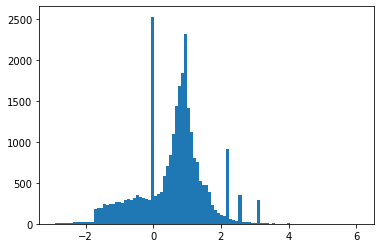

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

To keep this tutorial relatively short, use just the first 1,000 samples for validation, and the next 10,000 for training:

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

These datasets return individual examples. Use the `Dataset.batch` method to create batches of an appropriate size for training. Before batching, also remember to use `Dataset.shuffle` and `Dataset.repeat` on the training set.

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only densely-connected layers (`tf.keras.layers.Dense`) as a baseline, then create larger models, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `tf.keras.optimizers.schedules` to reduce the learning rate over time:

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `tf.keras.optimizers.schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1,000 epochs, 1/3 at 2,000 epochs, and so on.

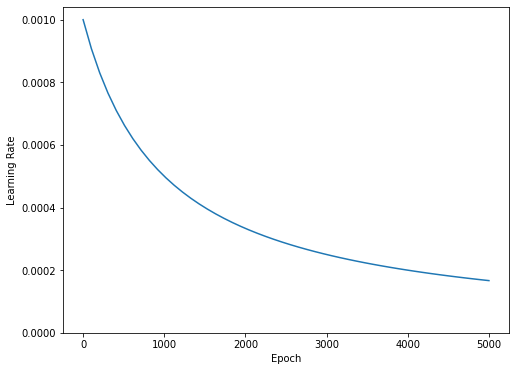

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `tf.keras.callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.


In [19]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

Start by training a model:

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                464       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 481


Trainable params: 481


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4896,  binary_crossentropy:0.8395,  loss:0.8395,  val_accuracy:0.5070,  val_binary_crossentropy:0.7700,  val_loss:0.7700,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6016,  binary_crossentropy:0.6240,  loss:0.6240,  val_accuracy:0.5910,  val_binary_crossentropy:0.6256,  val_loss:0.6256,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6269,  binary_crossentropy:0.6103,  loss:0.6103,  val_accuracy:0.6110,  val_binary_crossentropy:0.6151,  val_loss:0.6151,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6484,  binary_crossentropy:0.5984,  loss:0.5984,  val_accuracy:0.6340,  val_binary_crossentropy:0.6038,  val_loss:0.6038,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6584,  binary_crossentropy:0.5905,  loss:0.5905,  val_accuracy:0.6340,  val_binary_crossentropy:0.5993,  val_loss:0.5993,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6694,  binary_crossentropy:0.5860,  loss:0.5860,  val_accuracy:0.6410,  val_binary_crossentropy:0.5979,  val_loss:0.5979,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6684,  binary_crossentropy:0.5831,  loss:0.5831,  val_accuracy:0.6550,  val_binary_crossentropy:0.5960,  val_loss:0.5960,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6748,  binary_crossentropy:0.5810,  loss:0.5810,  val_accuracy:0.6510,  val_binary_crossentropy:0.5967,  val_loss:0.5967,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6707,  binary_crossentropy:0.5795,  loss:0.5795,  val_accuracy:0.6580,  val_binary_crossentropy:0.5965,  val_loss:0.5965,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

Now check how the model did:

(0.5, 0.7)

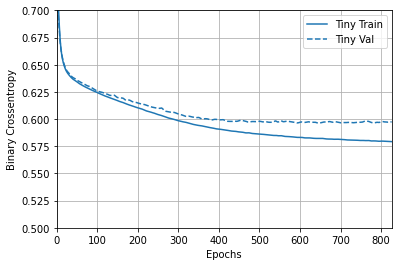

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

To check if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [25]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_2 (Dense)             (None, 16)                464       


 dense_3 (Dense)             (None, 16)                272       


 dense_4 (Dense)             (None, 1)                 17        


Total params: 753


Trainable params: 753


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4877,  binary_crossentropy:0.7209,  loss:0.7209,  val_accuracy:0.4860,  val_binary_crossentropy:0.7025,  val_loss:0.7025,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6212,  binary_crossentropy:0.6148,  loss:0.6148,  val_accuracy:0.6200,  val_binary_crossentropy:0.6184,  val_loss:0.6184,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6657,  binary_crossentropy:0.5853,  loss:0.5853,  val_accuracy:0.6570,  val_binary_crossentropy:0.5949,  val_loss:0.5949,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6774,  binary_crossentropy:0.5750,  loss:0.5750,  val_accuracy:0.6720,  val_binary_crossentropy:0.5868,  val_loss:0.5868,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6838,  binary_crossentropy:0.5683,  loss:0.5683,  val_accuracy:0.6760,  val_binary_crossentropy:0.5859,  val_loss:0.5859,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6897,  binary_crossentropy:0.5632,  loss:0.5632,  val_accuracy:0.6720,  val_binary_crossentropy:0.5863,  val_loss:0.5863,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6946,  binary_crossentropy:0.5593,  loss:0.5593,  val_accuracy:0.6670,  val_binary_crossentropy:0.5883,  val_loss:0.5883,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6963,  binary_crossentropy:0.5558,  loss:0.5558,  val_accuracy:0.6730,  val_binary_crossentropy:0.5869,  val_loss:0.5869,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.7006,  binary_crossentropy:0.5531,  loss:0.5531,  val_accuracy:0.6620,  val_binary_crossentropy:0.5894,  val_loss:0.5894,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Medium model

Now try three hidden layers with 64 units each:

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_5 (Dense)             (None, 64)                1856      


 dense_6 (Dense)             (None, 64)                4160      


 dense_7 (Dense)             (None, 64)                4160      


 dense_8 (Dense)             (None, 1)                 65        


Total params: 10,241


Trainable params: 10,241


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.4897,  binary_crossentropy:0.6952,  loss:0.6952,  val_accuracy:0.4970,  val_binary_crossentropy:0.6829,  val_loss:0.6829,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.7220,  binary_crossentropy:0.5194,  loss:0.5194,  val_accuracy:0.6450,  val_binary_crossentropy:0.6157,  val_loss:0.6157,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.7929,  binary_crossentropy:0.4219,  loss:0.4219,  val_accuracy:0.6490,  val_binary_crossentropy:0.7006,  val_loss:0.7006,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Large model

As an exercise, you can create an even larger model and check how quickly it begins overfitting. Next, add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_9 (Dense)             (None, 512)               14848     


 dense_10 (Dense)            (None, 512)               262656    


 dense_11 (Dense)            (None, 512)               262656    


 dense_12 (Dense)            (None, 512)               262656    


 dense_13 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5121,  binary_crossentropy:0.8038,  loss:0.8038,  val_accuracy:0.4670,  val_binary_crossentropy:0.6990,  val_loss:0.6990,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0021,  loss:0.0021,  val_accuracy:0.6500,  val_binary_crossentropy:1.8178,  val_loss:1.8178,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6590,  val_binary_crossentropy:2.4547,  val_loss:2.4547,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really figure out what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

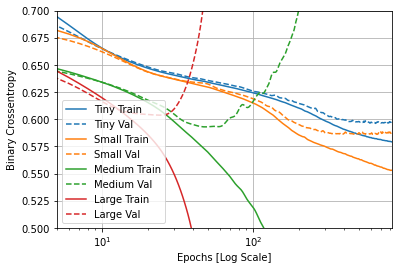

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook:

In [ ]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an `<iframe>` for convenience:

In [32]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

If you want to share TensorBoard results you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This step requires a Google account.

```
!tensorboard dev upload --logdir  {logdir}/sizes
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [33]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmp0j45s09l/tensorboard_logs/regularizers/Tiny')

In [34]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as demonstrated in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero, encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights—one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Add L2 weight regularization:

In [35]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_14 (Dense)            (None, 512)               14848     


 dense_15 (Dense)            (None, 512)               262656    


 dense_16 (Dense)            (None, 512)               262656    


 dense_17 (Dense)            (None, 512)               262656    


 dense_18 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5130,  binary_crossentropy:0.7964,  loss:2.3161,  val_accuracy:0.4900,  val_binary_crossentropy:0.6838,  val_loss:2.1253,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6464,  binary_crossentropy:0.6007,  loss:0.6227,  val_accuracy:0.6280,  val_binary_crossentropy:0.5894,  val_loss:0.6115,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6673,  binary_crossentropy:0.5865,  loss:0.6076,  val_accuracy:0.6830,  val_binary_crossentropy:0.5773,  val_loss:0.5984,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6767,  binary_crossentropy:0.5803,  loss:0.6010,  val_accuracy:0.6220,  val_binary_crossentropy:0.5999,  val_loss:0.6211,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6880,  binary_crossentropy:0.5677,  loss:0.5883,  val_accuracy:0.6750,  val_binary_crossentropy:0.5827,  val_loss:0.6033,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


(0.5, 0.7)

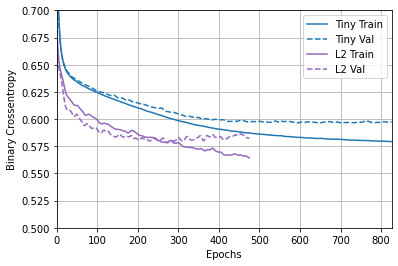

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As demonstrated in the diagram above, the `"L2"` regularized model is now much more competitive with the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

#### More info

There are two important things to note about this sort of regularization:

1. If you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [37]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

2. This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "decoupled weight decay" is used in optimizers like `tf.keras.optimizers.Ftrl` and `tfa.optimizers.AdamW`.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. For example, a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 1.3, 0, 1.1]`.

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In Keras, you can introduce dropout in a network via the `tf.keras.layers.Dropout` layer, which gets applied to the output of layer right before.

Add two dropout layers to your network to check how well they do at reducing overfitting:

In [38]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_19 (Dense)            (None, 512)               14848     


 dropout (Dropout)           (None, 512)               0         


 dense_20 (Dense)            (None, 512)               262656    


 dropout_1 (Dropout)         (None, 512)               0         


 dense_21 (Dense)            (None, 512)               262656    


 dropout_2 (Dropout)         (None, 512)               0         


 dense_22 (Dense)            (None, 512)               262656    


 dropout_3 (Dropout)         (None, 512)               0         


 dense_23 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5111,  binary_crossentropy:0.7826,  loss:0.7826,  val_accuracy:0.5150,  val_binary_crossentropy:0.6853,  val_loss:0.6853,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6559,  binary_crossentropy:0.5941,  loss:0.5941,  val_accuracy:0.6960,  val_binary_crossentropy:0.5853,  val_loss:0.5853,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6962,  binary_crossentropy:0.5544,  loss:0.5544,  val_accuracy:0.6870,  val_binary_crossentropy:0.5878,  val_loss:0.5878,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.7242,  binary_crossentropy:0.5066,  loss:0.5066,  val_accuracy:0.6770,  val_binary_crossentropy:0.6016,  val_loss:0.6016,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

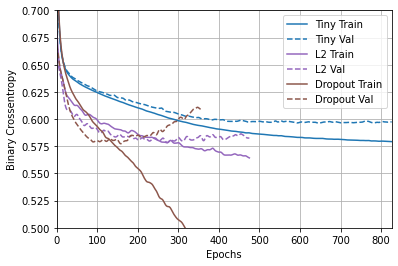

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

### Combined L2 + dropout

In [40]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_24 (Dense)            (None, 512)               14848     


 dropout_4 (Dropout)         (None, 512)               0         


 dense_25 (Dense)            (None, 512)               262656    


 dropout_5 (Dropout)         (None, 512)               0         


 dense_26 (Dense)            (None, 512)               262656    


 dropout_6 (Dropout)         (None, 512)               0         


 dense_27 (Dense)            (None, 512)               262656    


 dropout_7 (Dropout)         (None, 512)               0         


 dense_28 (Dense)            (None, 1)                 513       


Total params: 803,329


Trainable params: 803,329


Non-trainable params: 0


_________________________________________________________________



Epoch: 0, accuracy:0.5009,  binary_crossentropy:0.8059,  loss:0.9642,  val_accuracy:0.4610,  val_binary_crossentropy:0.7068,  val_loss:0.8645,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 100, accuracy:0.6455,  binary_crossentropy:0.6040,  loss:0.6345,  val_accuracy:0.6240,  val_binary_crossentropy:0.5893,  val_loss:0.6197,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 200, accuracy:0.6583,  binary_crossentropy:0.5897,  loss:0.6156,  val_accuracy:0.6720,  val_binary_crossentropy:0.5737,  val_loss:0.5996,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 300, accuracy:0.6743,  binary_crossentropy:0.5808,  loss:0.6092,  val_accuracy:0.6860,  val_binary_crossentropy:0.5623,  val_loss:0.5907,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 400, accuracy:0.6748,  binary_crossentropy:0.5779,  loss:0.6084,  val_accuracy:0.6970,  val_binary_crossentropy:0.5520,  val_loss:0.5825,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 500, accuracy:0.6843,  binary_crossentropy:0.5704,  loss:0.6033,  val_accuracy:0.6760,  val_binary_crossentropy:0.5598,  val_loss:0.5927,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 600, accuracy:0.6868,  binary_crossentropy:0.5679,  loss:0.6028,  val_accuracy:0.6880,  val_binary_crossentropy:0.5448,  val_loss:0.5796,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 700, accuracy:0.6944,  binary_crossentropy:0.5599,  loss:0.5966,  val_accuracy:0.6930,  val_binary_crossentropy:0.5480,  val_loss:0.5847,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


Epoch: 800, accuracy:0.6891,  binary_crossentropy:0.5571,  loss:0.5951,  val_accuracy:0.6950,  val_binary_crossentropy:0.5466,  val_loss:0.5846,  
.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

(0.5, 0.7)

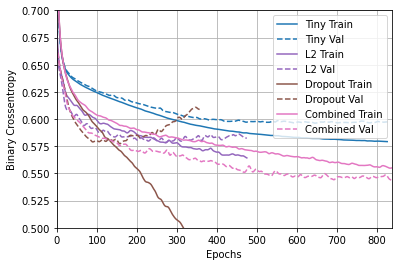

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

This model with the `"Combined"` regularization is obviously the best one so far.

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded  tensorboard viewer inside a notebook, copy the following into a code-cell:

```
%tensorboard --logdir {logdir}/regularizers
```

You can view the [results of a previous run](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

It's also included in an `<iframe>` for convenience:

In [42]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")


This was uploaded with:

```
!tensorboard dev upload --logdir  {logdir}/regularizers
```

## Conclusions

To recap, here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* [Data augmentation](../images/data_augmentation.ipynb)
* Batch normalization (`tf.keras.layers.BatchNormalization`)

Remember that each method can help on its own, but often combining them can be even more effective.